In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("cleaned_pose_data.csv")
df.head()

,video_name,frame_id,person_id,joint_id,x,y,score
0,Hoang_Hearn,0,0,0,257.707092,629.240845,0.171782
1,Hoang_Hearn,0,0,1,260.629639,621.918457,0.159820
2,Hoang_Hearn,0,0,2,258.474365,621.872253,0.032368
3,Hoang_Hearn,0,0,3,264.950623,621.193115,0.924104
4,Hoang_Hearn,0,0,4,286.588562,618.743774,0.355051


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561272 entries, 0 to 561271
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   video_name  561272 non-null  object 
 1   frame_id    561272 non-null  int64  
 2   person_id   561272 non-null  int64  
 3   joint_id    561272 non-null  int64  
 4   x           561272 non-null  float64
 5   y           561272 non-null  float64
 6   score       561272 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 30.0+ MB


In [4]:
COCO_JOINTS = {
    0: "nose",
    1: "left_eye",
    2: "right_eye",
    3: "left_ear",
    4: "right_ear",
    5: "left_shoulder",
    6: "right_shoulder",
    7: "left_elbow",
    8: "right_elbow",
    9: "left_wrist",
    10: "right_wrist",
    11: "left_hip",
    12: "right_hip",
    13: "left_knee",
    14: "right_knee",
    15: "left_ankle",
    16: "right_ankle",
}


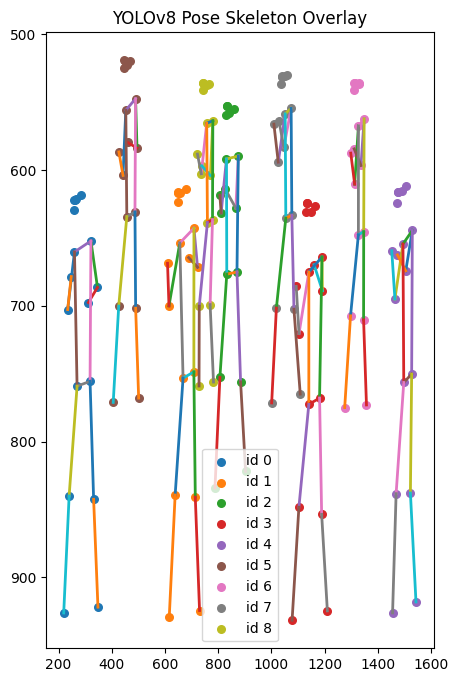

In [5]:
SKELETON = [
    (5, 7), (7, 9),       # left arm
    (6, 8), (8, 10),      # right arm
    (5, 6),               # shoulders
    (5, 11), (6, 12),     # torso
    (11, 12),
    (11, 13), (13, 15),   # left leg
    (12, 14), (14, 16),   # right leg
]

frame_df = df[
    (df['video_name'] == df['video_name'].iloc[0]) &
    (df['frame_id'] == df['frame_id'].iloc[200])
]

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 8))

for pid, g in frame_df.groupby('person_id'):
    plt.scatter(g['x'], g['y'], s=30, label=f"id {pid}")
    for j1, j2 in SKELETON:
        p1 = g[g['joint_id'] == j1]
        p2 = g[g['joint_id'] == j2]
        if not p1.empty and not p2.empty:
            plt.plot(
                [p1['x'].iloc[0], p2['x'].iloc[0]],
                [p1['y'].iloc[0], p2['y'].iloc[0]],
                linewidth=2
            )

plt.gca().invert_yaxis()
plt.legend()
plt.title("YOLOv8 Pose Skeleton Overlay")
plt.show()


YOLOv8-pose “ไม่ได้บังคับให้หัวเป็น skeleton หลัก”

YOLOv8-pose (COCO 17) แบ่ง joint เป็น 2 กลุ่มโดยธรรมชาติ:

🔹 Body skeleton (แขน–ขา–ลำตัว)

เชื่อมกันชัด:

shoulders (5,6)

hips (11,12)

elbows, knees, ankles

🔹 Head keypoints (detached)

nose (0)

eyes (1,2)

ears (3,4)

👉 หัวไม่ได้เชื่อมกับ shoulder โดย default

เพราะ:

หัวมี jitter สูง

บาง frame ตรวจเจอแค่หน้า / แค่ตัว

COCO evaluation ก็ไม่ได้ใช้ head chain เป็น backbone

ดังนั้น skeleton ที่คุณเห็น = “ตัวคนครบ” แต่ “หัวลอย”

In [7]:
from ultralytics import YOLO

pose_model = YOLO("yolov8l-pose.pt") 

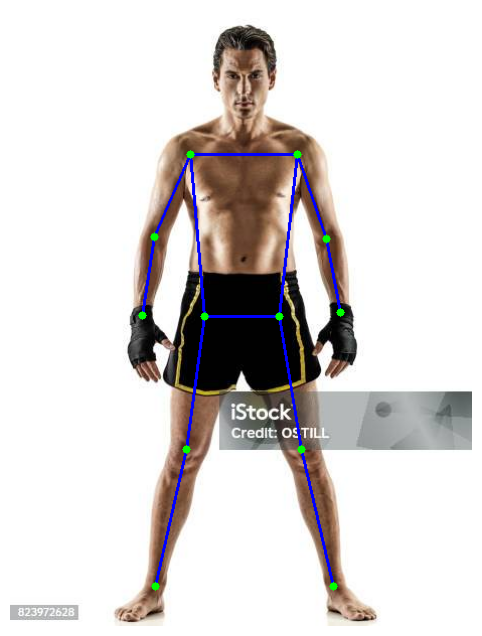

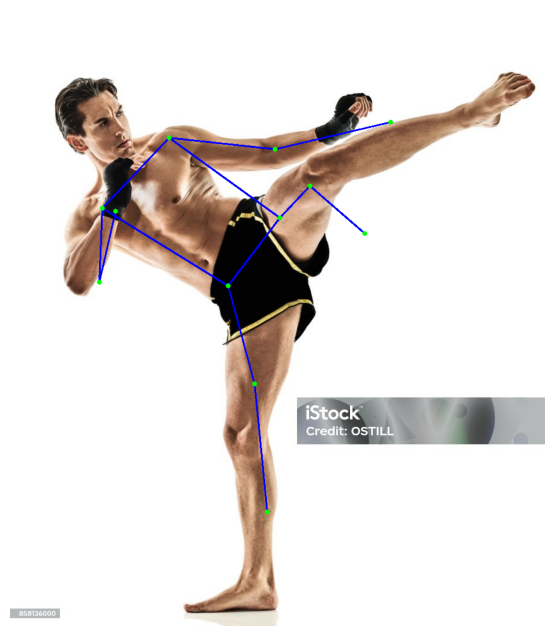

In [12]:
def pose_detection_plot(frame):
    if frame is None:
        raise ValueError("ไม่พบไฟล์ภาพ")

    # ---- pose inference ----
    results = pose_model(
        frame,
        conf=0.25,
        device=0,
        verbose=False
    )

    r = results[0]

    # ---- draw keypoints + skeleton ----
    if r.keypoints is not None:
        keypoints = r.keypoints.xy.cpu().numpy()  # [N,17,2]

        for person in keypoints:

            # วาดเส้น skeleton
            for j1, j2 in SKELETON:
                x1, y1 = person[j1]
                x2, y2 = person[j2]

                if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                    cv2.line(
                        frame,
                        (int(x1), int(y1)),
                        (int(x2), int(y2)),
                        (255, 0, 0),  # สีฟ้า
                        2
                    )

            # วาดเฉพาะจุดที่อยู่ใน skeleton
            used_joints = set(j for pair in SKELETON for j in pair)

            for j in used_joints:
                x, y = person[j]
                if x > 0 and y > 0:
                    cv2.circle(
                        frame,
                        (int(x), int(y)),
                        4,
                        (0, 255, 0),  # เขียว
                        -1
                    )

    # ---- display in ipynb ----
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()

# ---- load image ----
image_path_list = ["istockphoto1.jpg", "istockphoto2.jpg"]

for image_path in image_path_list:
    frame = cv2.imread(image_path)
    pose_detection_plot(frame)

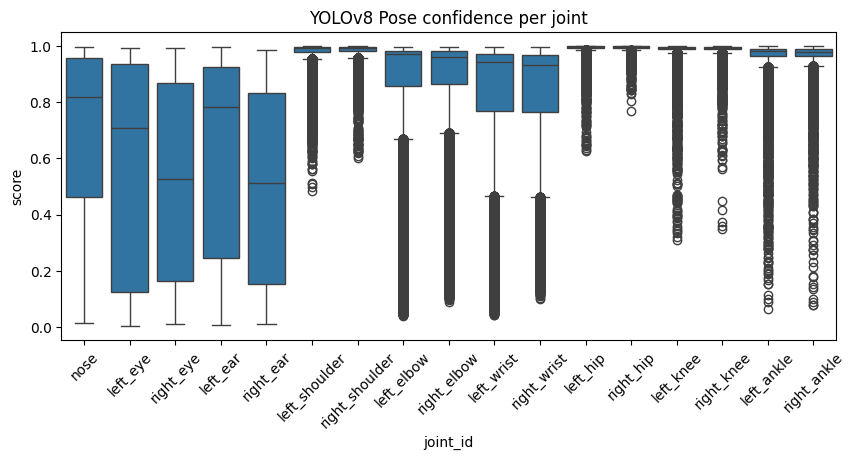

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(
    data=df,
    x='joint_id',
    y='score'
)
plt.xticks(
    ticks=range(17),
    labels=[COCO_JOINTS[i] for i in range(17)],
    rotation=45
)
plt.title("YOLOv8 Pose confidence per joint")
plt.show()


ข้อมูลจากกราฟ:

ความมั่นใจสูง:

โหนดที่มีคะแนนสูงเช่น nose, left_eye, right_eye, left_ear, แสดงว่าโมเดลมีความมั่นใจสูงในตำแหน่งเหล่านี้.

จุด outlier (วงกลมที่อยู่นอก whiskers) แสดงว่าแม้ว่าผลลัพธ์โดยรวมจะมีความมั่นใจสูง แต่บางครั้งอาจมีข้อผิดพลาดที่ทำให้คะแนนต่ำ (outlier).

ข้อที่โมเดลไม่มั่นใจ:

โหนดที่มี whiskers ยาวมาก (เช่น left_wrist, left_ankle) แสดงว่าโมเดลมีความมั่นใจน้อยในการทำนายตำแหน่งเหล่านี้ ซึ่งอาจจะเป็นตำแหน่งที่โมเดลยากที่จะทำนายอย่างถูกต้อง.

ข้อที่มี outliers เยอะ ๆ เช่น left_ankle, right_ankle ก็แสดงถึงการทำนายที่ไม่เสถียรในจุดเหล่านี้.

ข้อสังเกต:

ข้อที่มี คะแนนการกระจายกว้าง เช่น left_wrist, right_knee แสดงว่าโมเดลอาจมีความไม่แน่นอนสูงในการทำนายตำแหน่งเหล่านี้.

ข้อที่มี คะแนนที่ไม่ค่อยเปลี่ยนแปลง เช่น left_eye, right_eye แสดงว่าโมเดลมีความมั่นใจในตำแหน่งของดวงตาได้ดีกว่า.

ACTION DISTRIBUTION

Summary Table:
               Action  Count  Percentage (%)
      Narai_Kwang_Jug   7296           22.10
Kum_Pa_Gun_Poong_Hork   7029           21.29
          Hoang_Hearn   6498           19.68
  Phra_Ram_Phang_Sorn   5139           15.57
   Mek_Khara_Lor_Kaew   4068           12.32
     Tad_Mai_Khom_Nam   2986            9.04


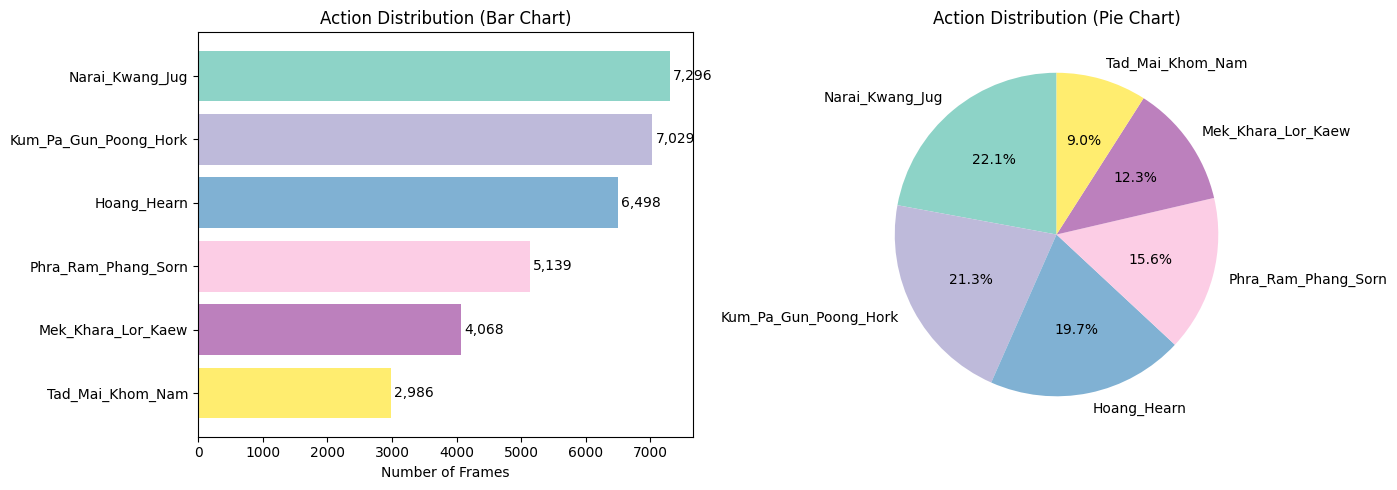

In [14]:
# คำนวณ action counts และ percentage
action_counts = df[df['joint_id'] == 0]['video_name'].value_counts()
action_percentages = df[df['joint_id'] == 0]['video_name'].value_counts(normalize=True) * 100

print("=" * 70)
print("ACTION DISTRIBUTION")
print("=" * 70)

# แสดงตาราง
action_summary = pd.DataFrame({
    'Action': action_counts.index,
    'Count': action_counts.values,
    'Percentage (%)': action_percentages.values.round(2)
})
print("\nSummary Table:")
print(action_summary.to_string(index=False))

# สร้าง Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar Chart
colors = plt.cm.Set3(np.linspace(0, 1, len(action_counts)))
bars = axes[0].barh(action_counts.index, action_counts.values, color=colors)
axes[0].set_xlabel('Number of Frames')
axes[0].set_title('Action Distribution (Bar Chart)')
axes[0].invert_yaxis()

# เพิ่มตัวเลขบน bar
for bar, count in zip(bars, action_counts.values):
    axes[0].text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                 f'{count:,}', va='center', fontsize=10)

# Pie Chart
axes[1].pie(action_counts.values, labels=action_counts.index, 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Action Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

PERSON ID ANALYSIS

Frames per Person:
 person_id  frame_count
         0         3669
         1         3669
         2         3669
         3         3669
         4         3669
         5         3669
         6         3669
         7         3669
         8         3664

Statistics:
   Total Unique Persons: 9
   Max Frames per Person: 3,669
   Min Frames per Person: 3,664
   Mean Frames per Person: 3668.44
   Median Frames per Person: 3669.00

PERSONS PER ACTION
               Action  Unique Persons
          Hoang_Hearn               9
Kum_Pa_Gun_Poong_Hork               9
   Mek_Khara_Lor_Kaew               9
      Narai_Kwang_Jug               9
  Phra_Ram_Phang_Sorn               9
     Tad_Mai_Khom_Nam               9


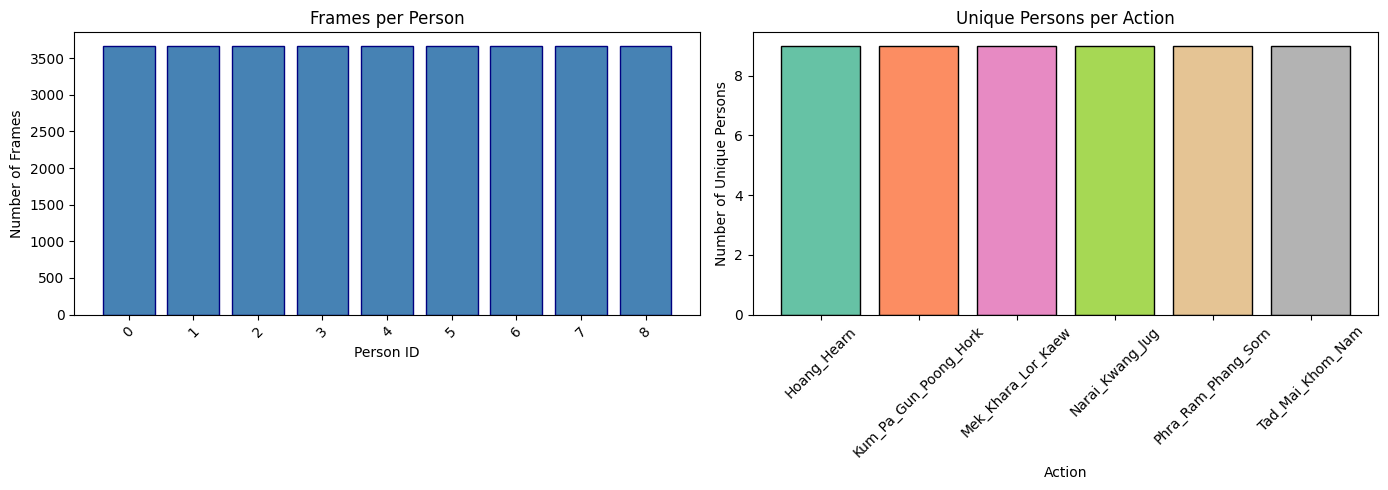

In [15]:
# นับ frames ต่อ person
person_frame_counts = df[df['joint_id'] == 0].groupby('person_id').size().reset_index(name='frame_count')
person_frame_counts = person_frame_counts.sort_values('frame_count', ascending=False)

print("=" * 70)
print("PERSON ID ANALYSIS")
print("=" * 70)

print("\nFrames per Person:")
print(person_frame_counts.head(10).to_string(index=False))

print(f"\nStatistics:")
print(f"   Total Unique Persons: {len(person_frame_counts)}")
print(f"   Max Frames per Person: {person_frame_counts['frame_count'].max():,}")
print(f"   Min Frames per Person: {person_frame_counts['frame_count'].min():,}")
print(f"   Mean Frames per Person: {person_frame_counts['frame_count'].mean():.2f}")
print(f"   Median Frames per Person: {person_frame_counts['frame_count'].median():.2f}")

# Person distribution per action
print("\n" + "=" * 70)
print("PERSONS PER ACTION")
print("=" * 70)

person_per_action = df[df['joint_id'] == 0].groupby('video_name')['person_id'].nunique().reset_index()
person_per_action.columns = ['Action', 'Unique Persons']
print(person_per_action.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frames per person
axes[0].bar(person_frame_counts['person_id'].astype(str), person_frame_counts['frame_count'], 
            color='steelblue', edgecolor='navy')
axes[0].set_xlabel('Person ID')
axes[0].set_ylabel('Number of Frames')
axes[0].set_title('Frames per Person')
axes[0].tick_params(axis='x', rotation=45)

# Persons per action
colors = plt.cm.Set2(np.linspace(0, 1, len(person_per_action)))
axes[1].bar(person_per_action['Action'], person_per_action['Unique Persons'], 
            color=colors, edgecolor='black')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Number of Unique Persons')
axes[1].set_title('Unique Persons per Action')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# นับ frames ต่อ person สำหรับข้อมูลที่มี label
person_labeled_counts = df[df['joint_id'] == 0].groupby('person_id').agg({
    'frame_id': 'count',
    'video_name': lambda x: x.nunique()
}).reset_index()
person_labeled_counts.columns = ['person_id', 'labeled_frames', 'actions_count']
person_labeled_counts = person_labeled_counts.sort_values('labeled_frames', ascending=False)

print("\n" + "=" * 70)
print("PERSON IDs INFO")
print("=" * 70)

print("\nPersons with Labeled Frames:")
print(person_labeled_counts.head(10).to_string(index=False))

print("\n" + "=" * 70)



PERSON IDs INFO

Persons with Labeled Frames:
 person_id  labeled_frames  actions_count
         0            3669              6
         1            3669              6
         2            3669              6
         3            3669              6
         4            3669              6
         5            3669              6
         6            3669              6
         7            3669              6
         8            3664              6



id ที่ไม่มีการ merged เข้า id ตัวเอง (to_id) และถูก merged ไป id อื่น (from_id) -> การ tracking pose ถูกต้องทุก skeleton เหมาะกับการเลือกเป็น train set

selected id: 0, 1, 2

ข้อมูลจาก data processing

และมี frame per person ครบถ้วน

In [17]:
pose_name_list = df['video_name'].unique().tolist()
person_id_list = df['person_id'].unique().tolist()
joint_id_list = df['joint_id'].unique().tolist()

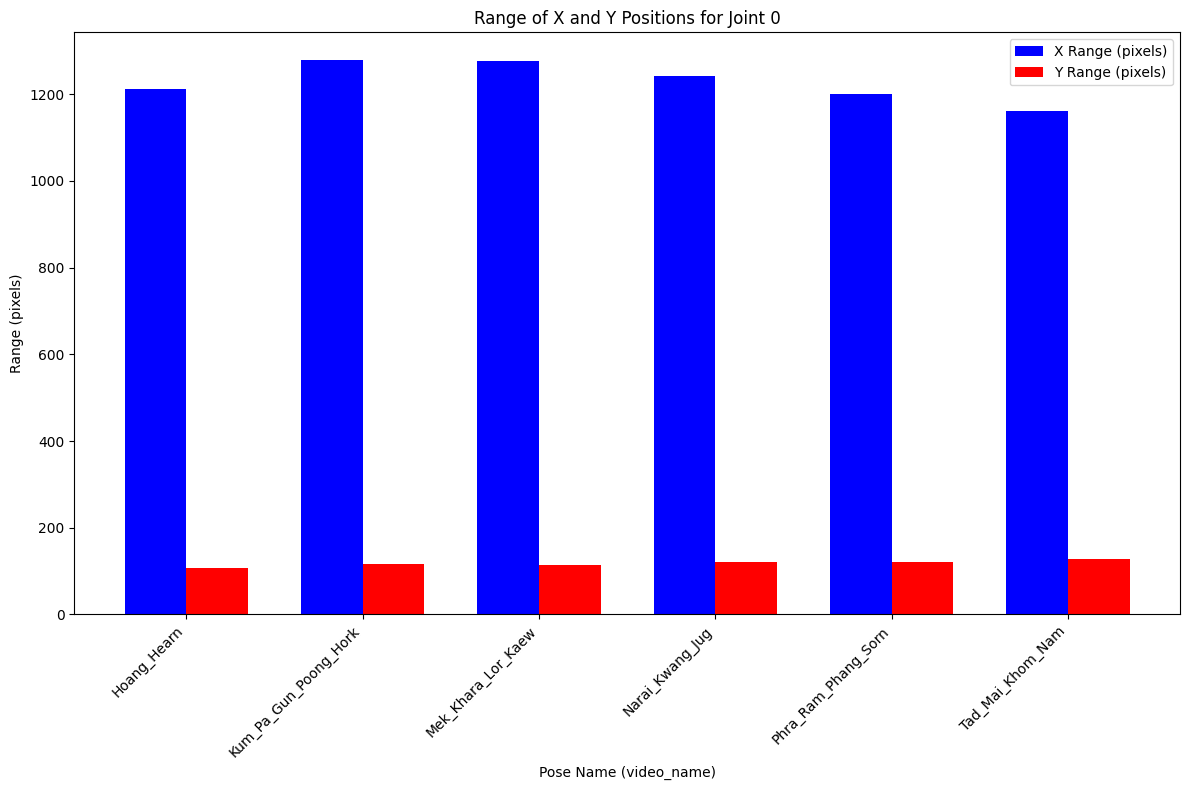

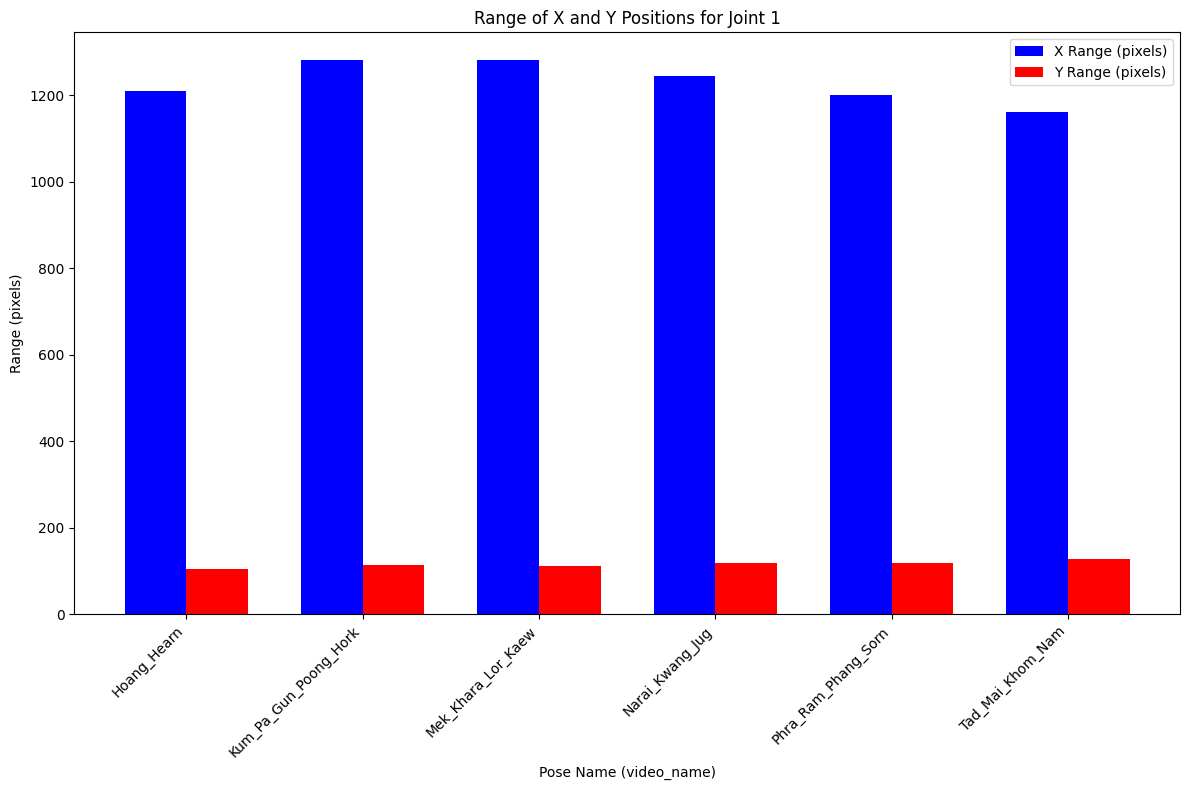

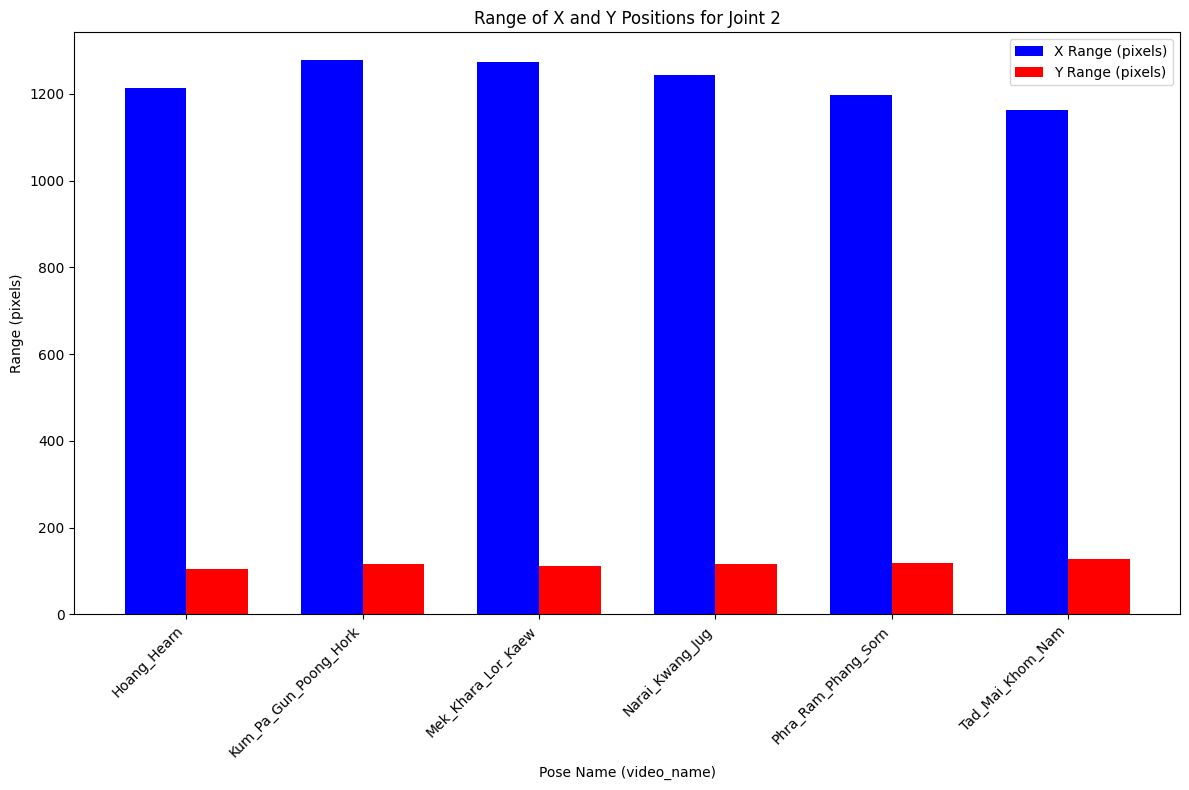

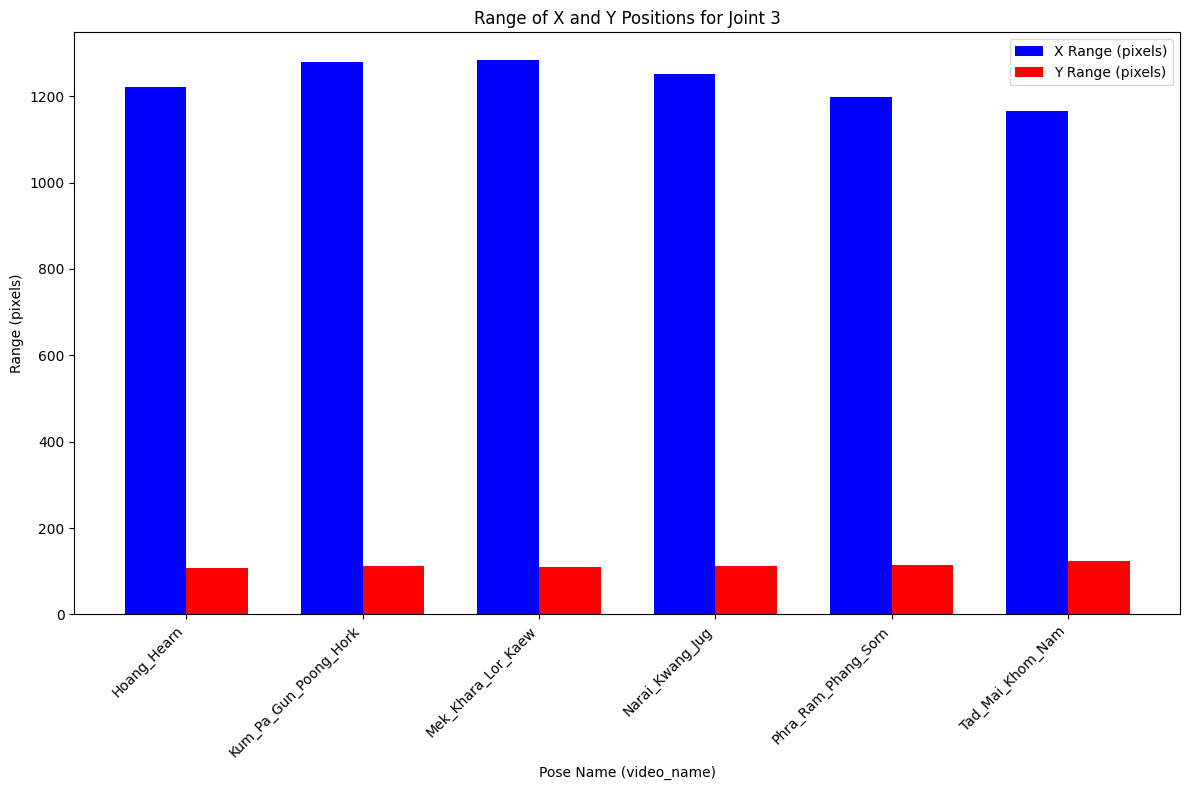

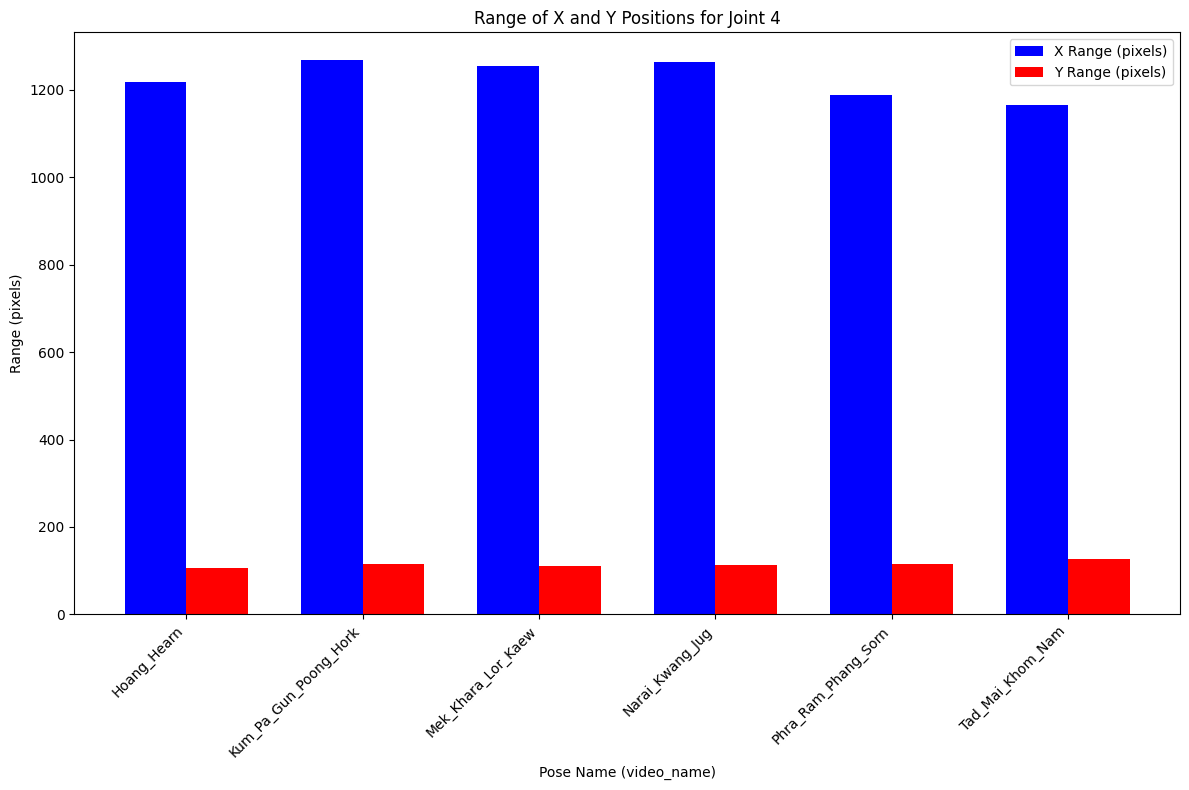

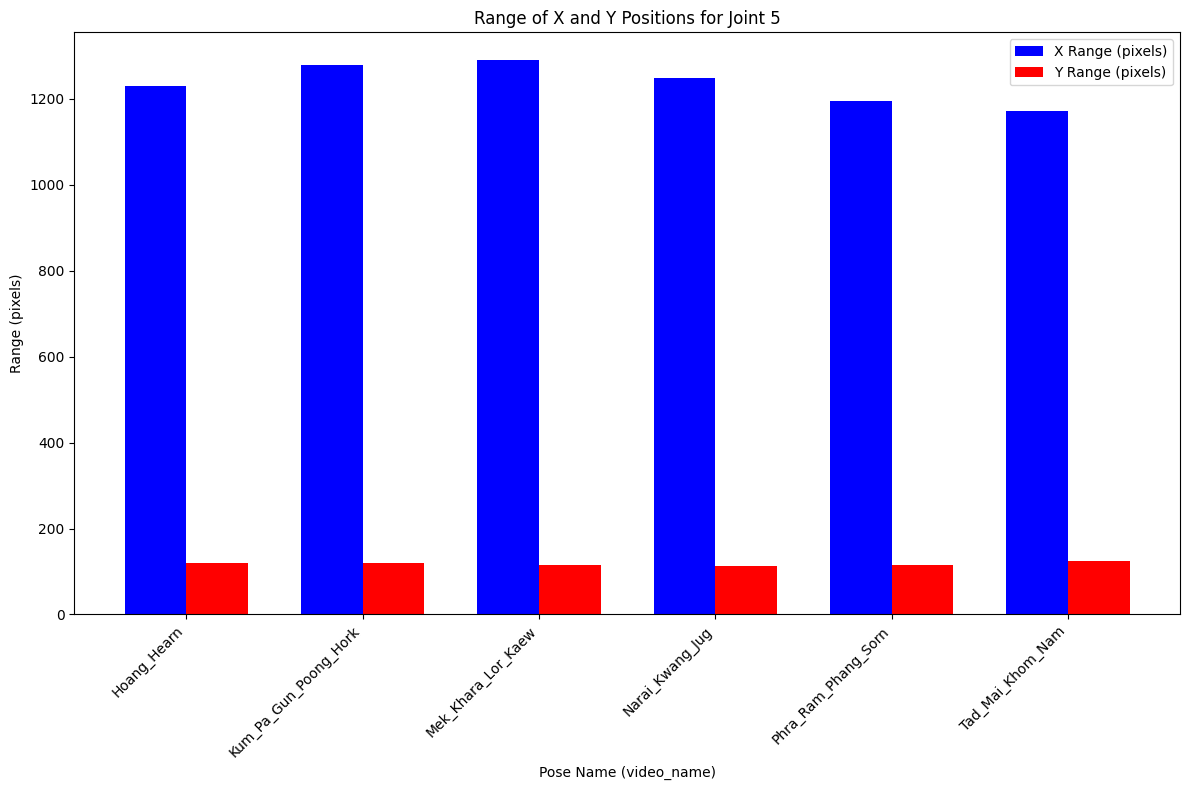

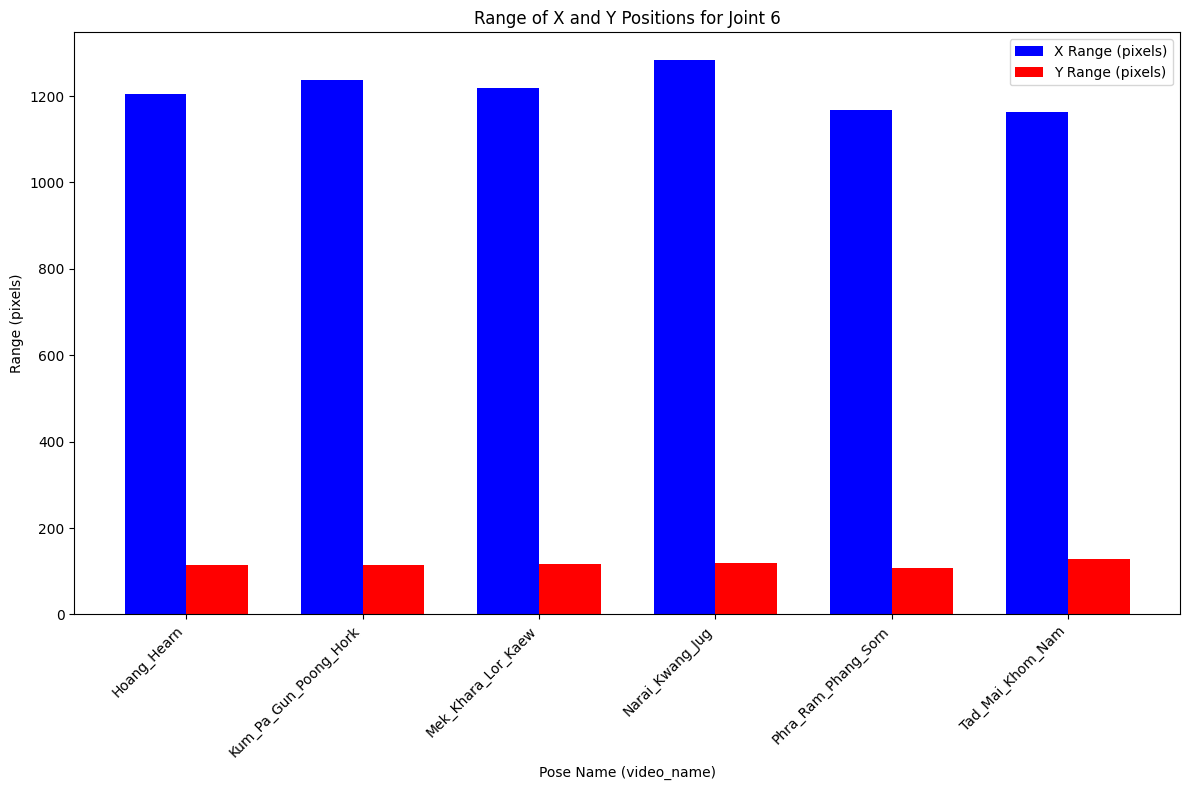

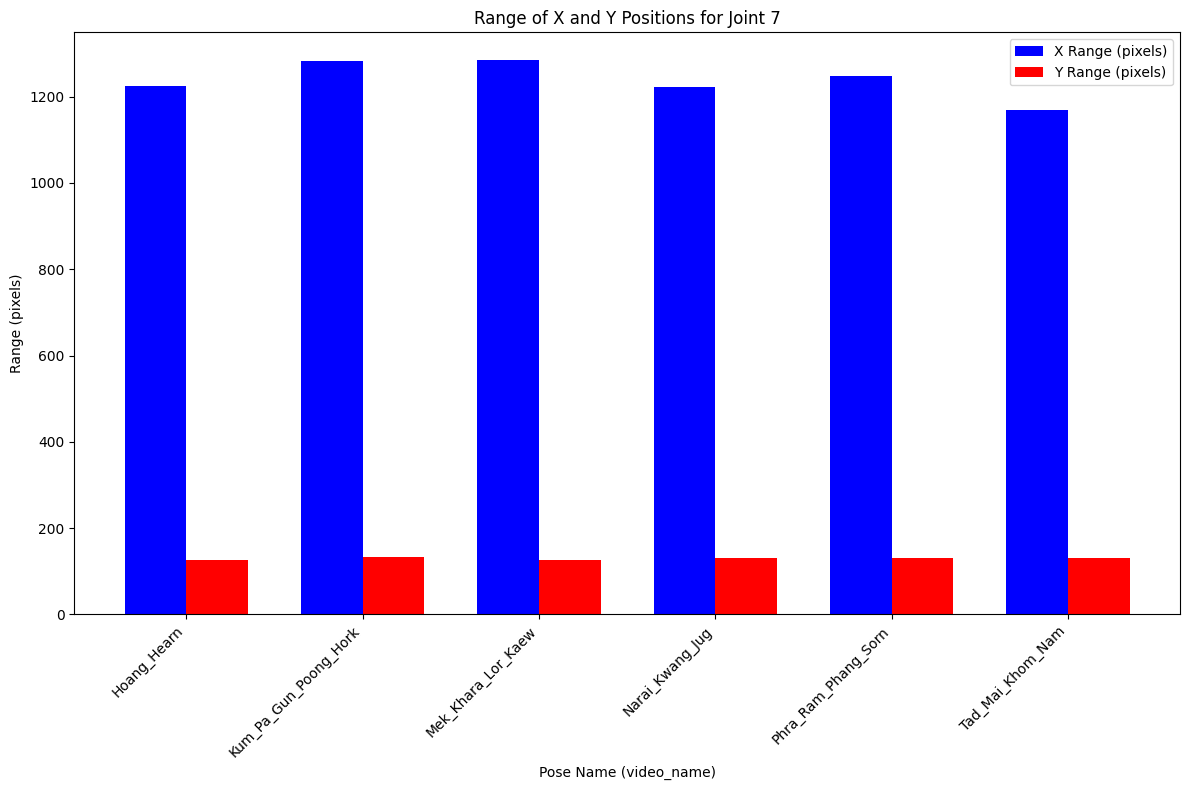

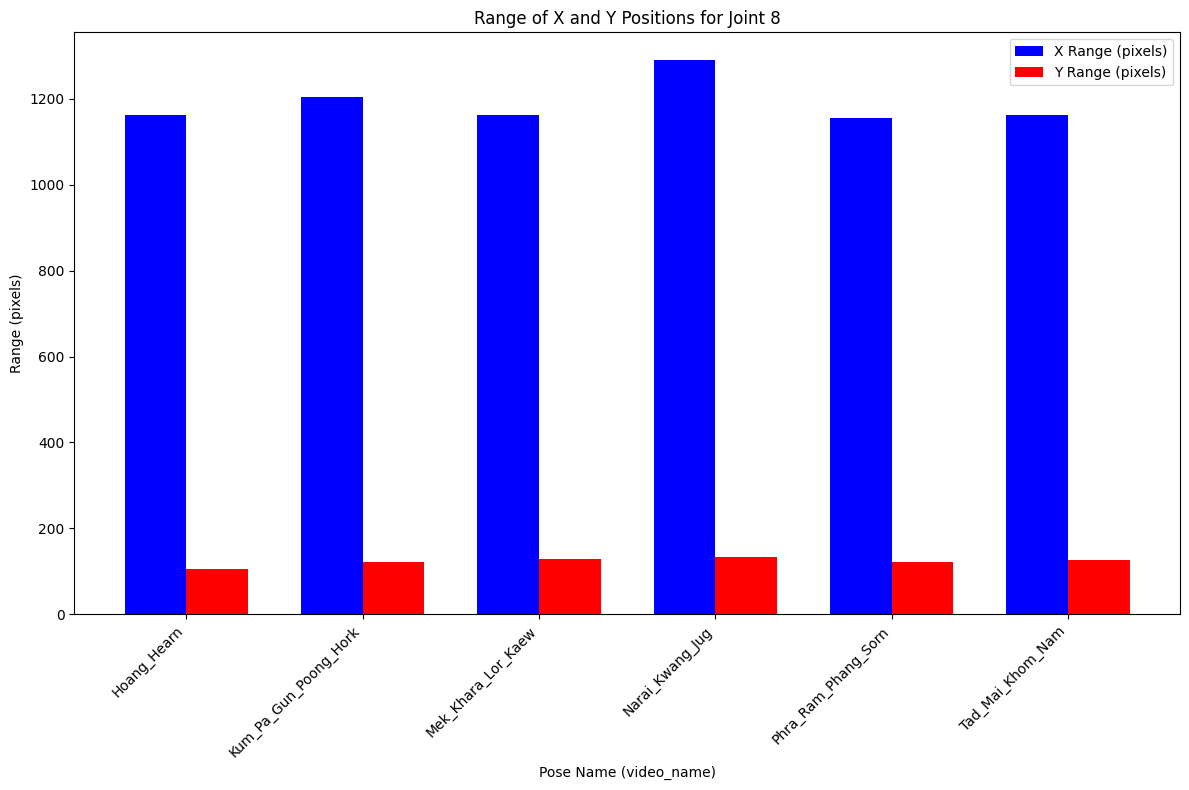

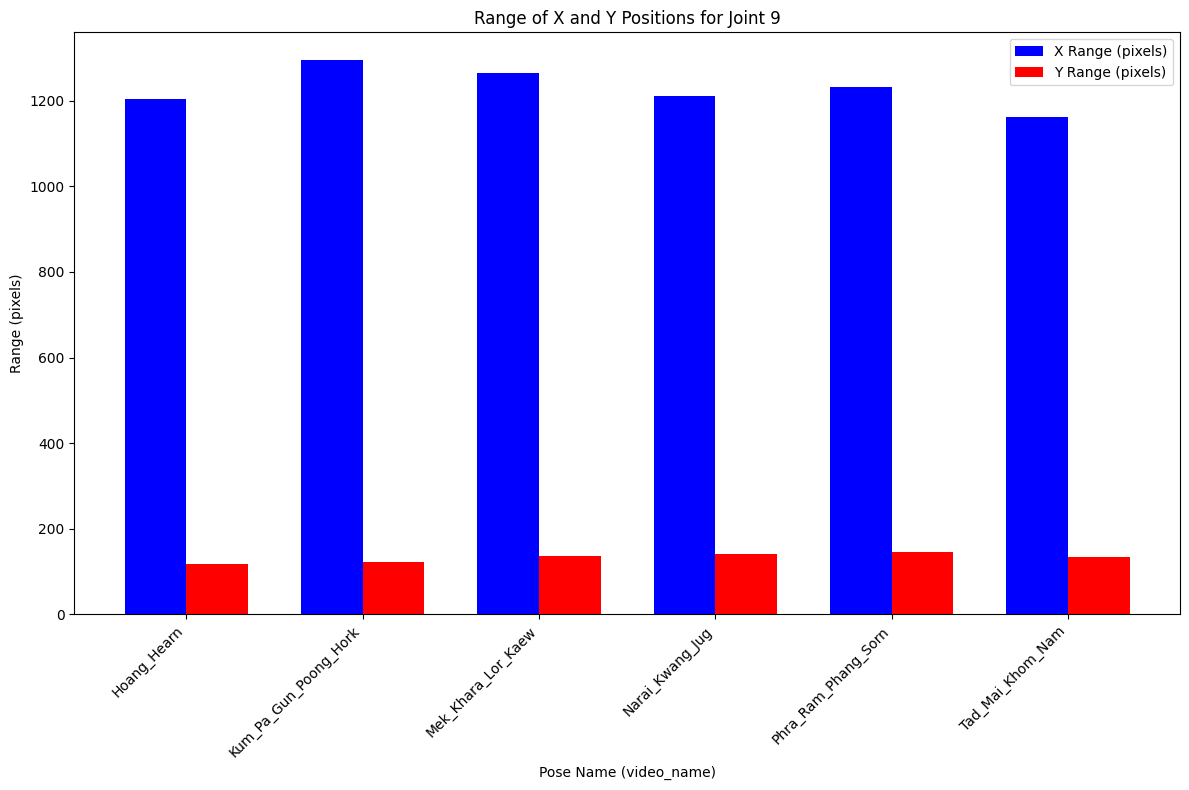

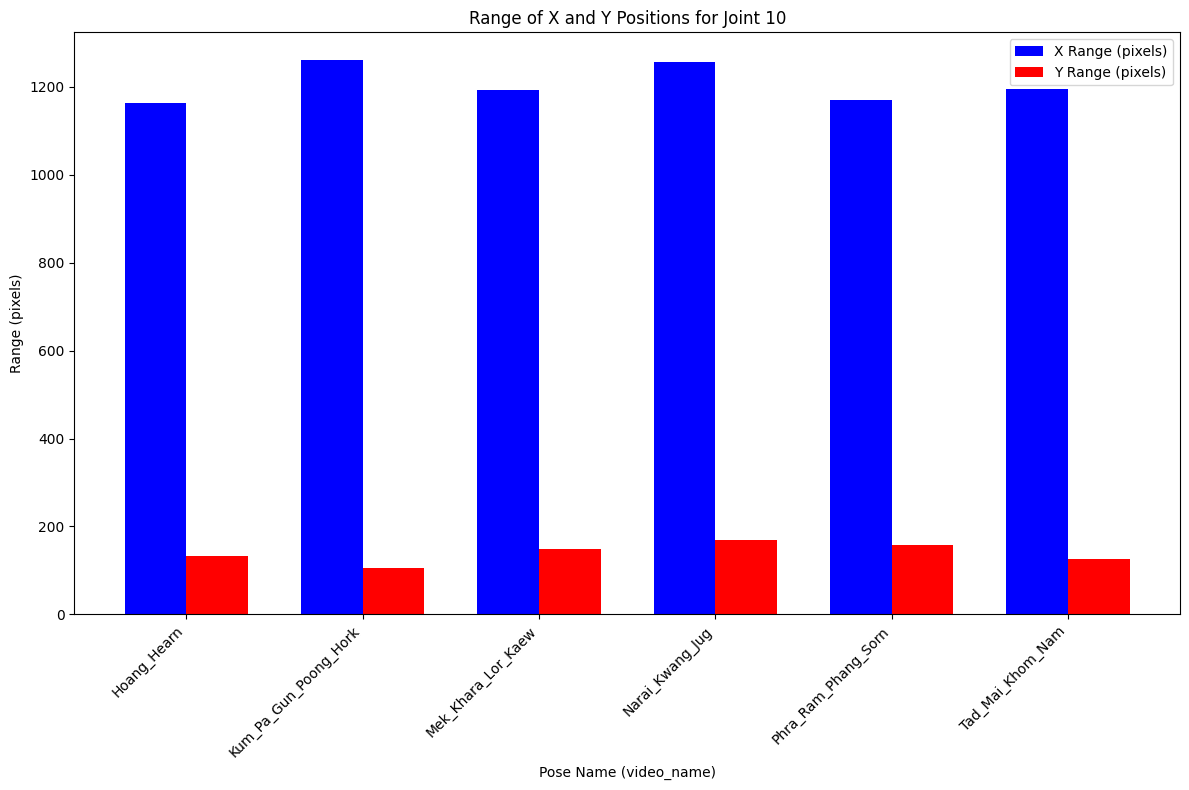

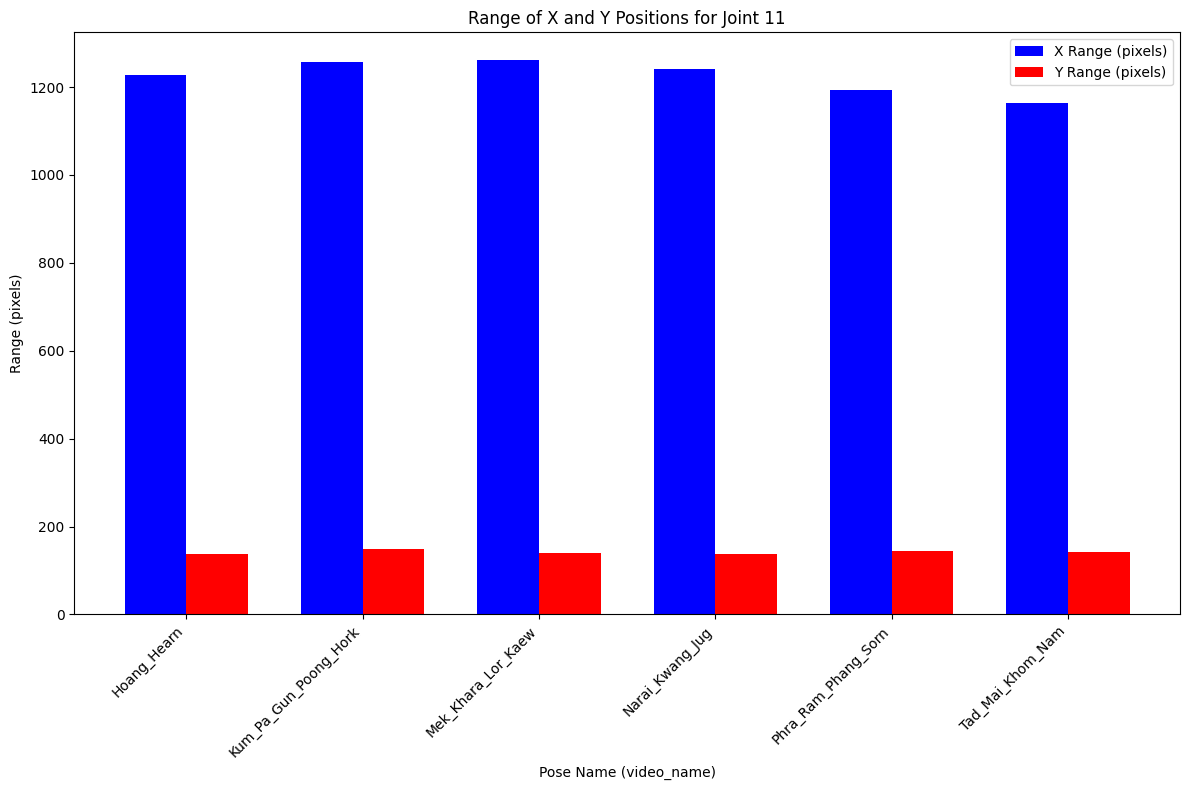

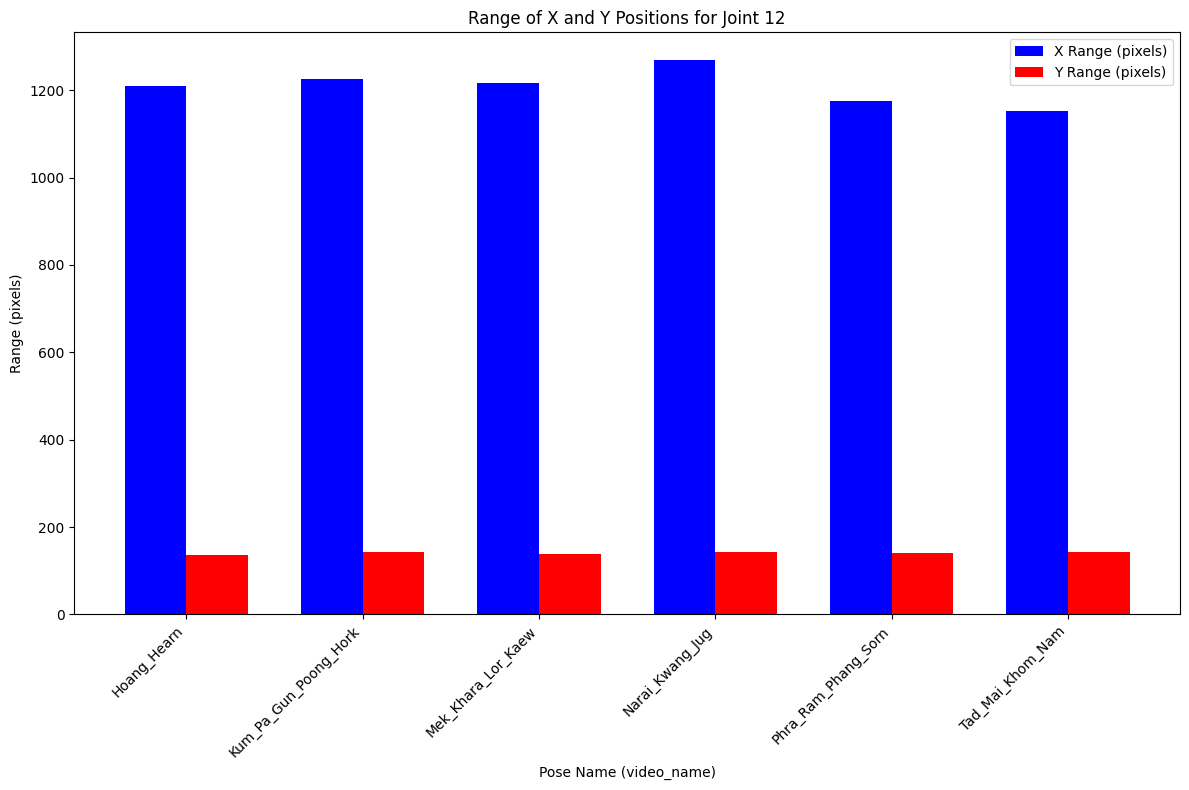

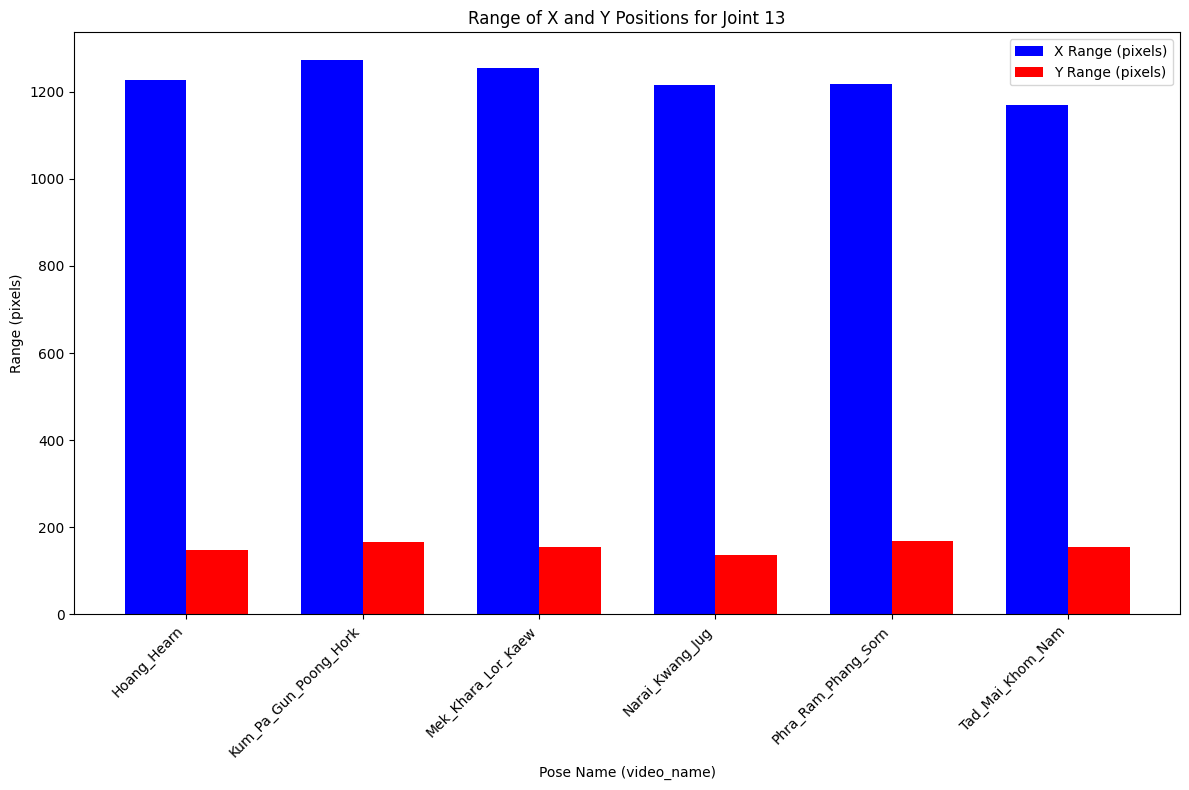

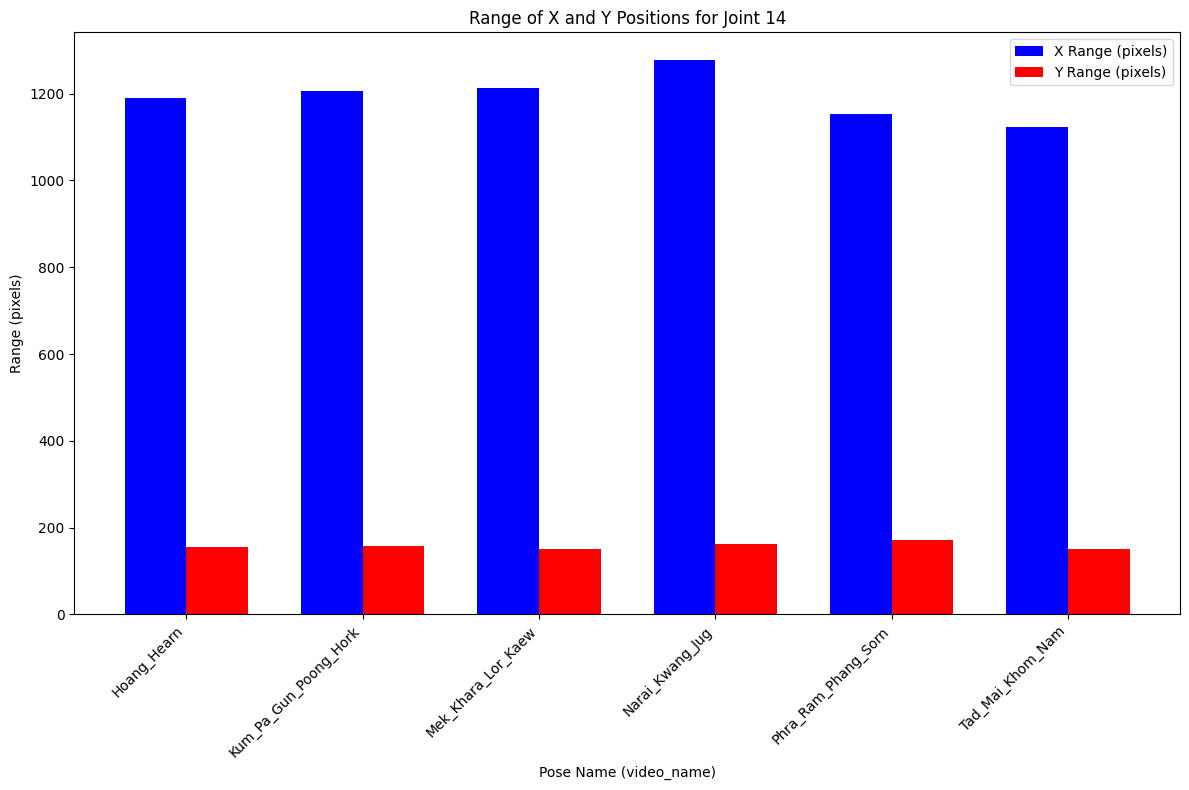

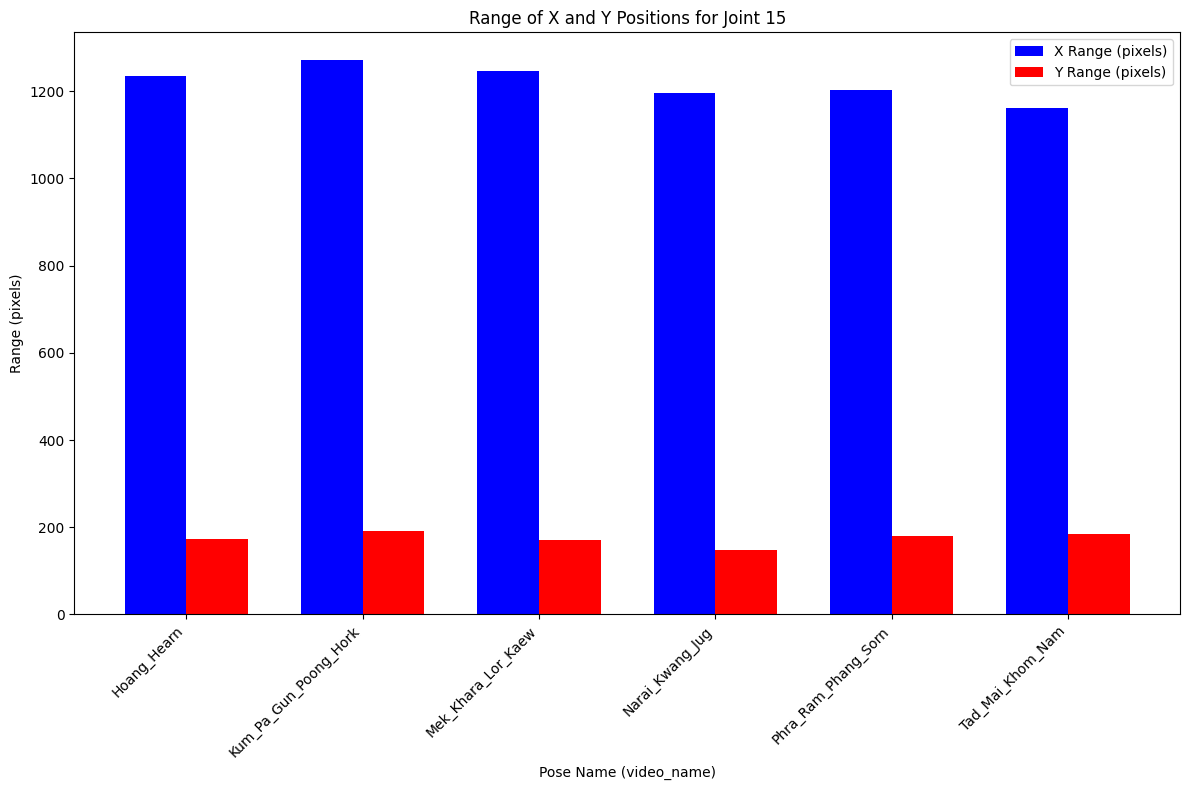

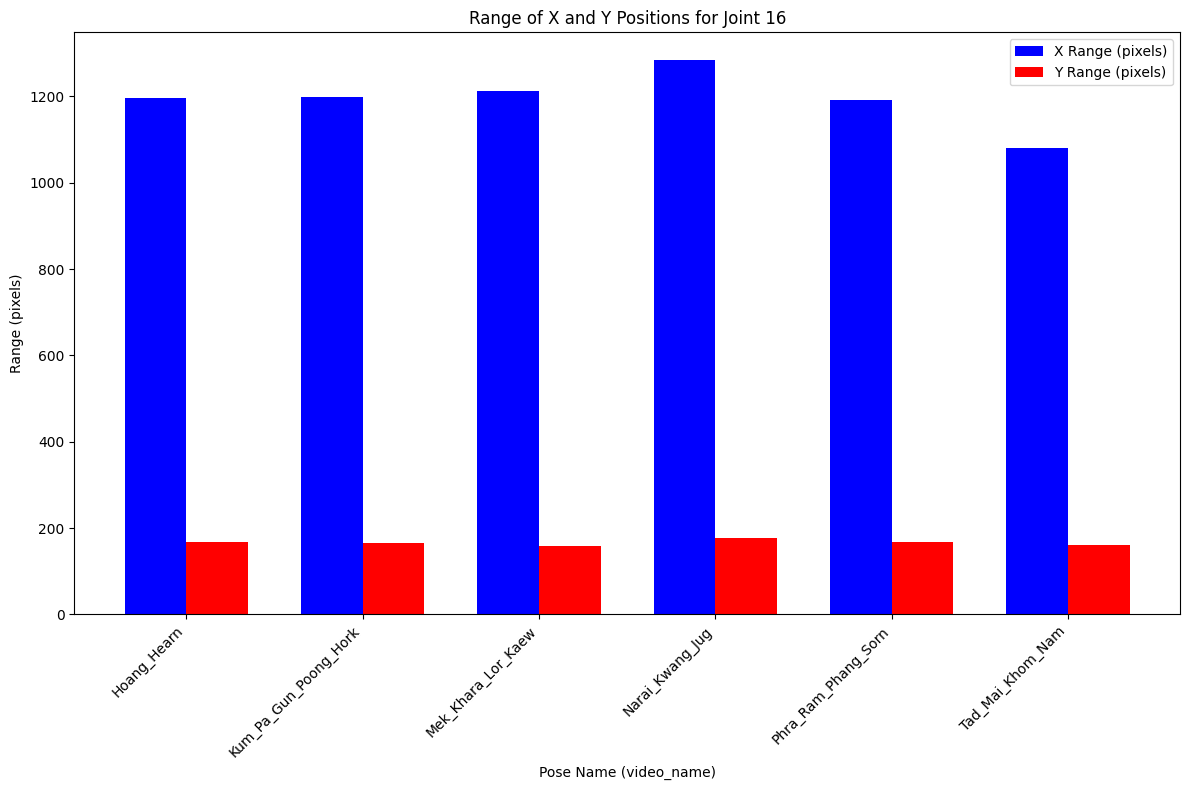

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# กรองข้อมูลเฉพาะ frame_id == 0
frame_data = df[df['frame_id'] == 0]

# สร้างกราฟสำหรับแต่ละ joint_id
for joint_id, joint_group in frame_data.groupby('joint_id'):
    # สร้าง dictionaries เพื่อเก็บ range ของ x และ y สำหรับทุก video_name
    joint_x_range = {}
    joint_y_range = {}
    labels = []

    # คำนวณ range ของ x และ y สำหรับแต่ละ video_name
    for video_name, video_group in joint_group.groupby('video_name'):
        # คำนวณ range ของ x และ y
        x_range = (video_group['x'].min(), video_group['x'].max())
        y_range = (video_group['y'].min(), video_group['y'].max())
        
        # เก็บค่า range ใน dictionary
        joint_x_range[video_name] = x_range
        joint_y_range[video_name] = y_range
        labels.append(video_name)

    # Convert to lists for plotting
    x_ranges = [range_tuple[1] - range_tuple[0] for range_tuple in joint_x_range.values()]
    y_ranges = [range_tuple[1] - range_tuple[0] for range_tuple in joint_y_range.values()]

    # สร้างกราฟ Bar Plot เพื่อแสดง range ของ x และ y สำหรับทุก video_name
    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.35
    index = np.arange(len(labels))

    # พล็อต x range และ y range ในกราฟเดียวกัน
    bar1 = ax.bar(index, x_ranges, bar_width, label='X Range (pixels)', color='blue')
    bar2 = ax.bar(index + bar_width, y_ranges, bar_width, label='Y Range (pixels)', color='red')

    # ปรับแต่งกราฟ
    ax.set_xlabel('Pose Name (video_name)')
    ax.set_ylabel('Range (pixels)')
    ax.set_title(f'Range of X and Y Positions for Joint {joint_id}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19452\4050564876.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frame_data = df.groupby('video_name').apply(lambda x: x[x['frame_id'] == x['frame_id'].max()]).reset_index(drop=True)


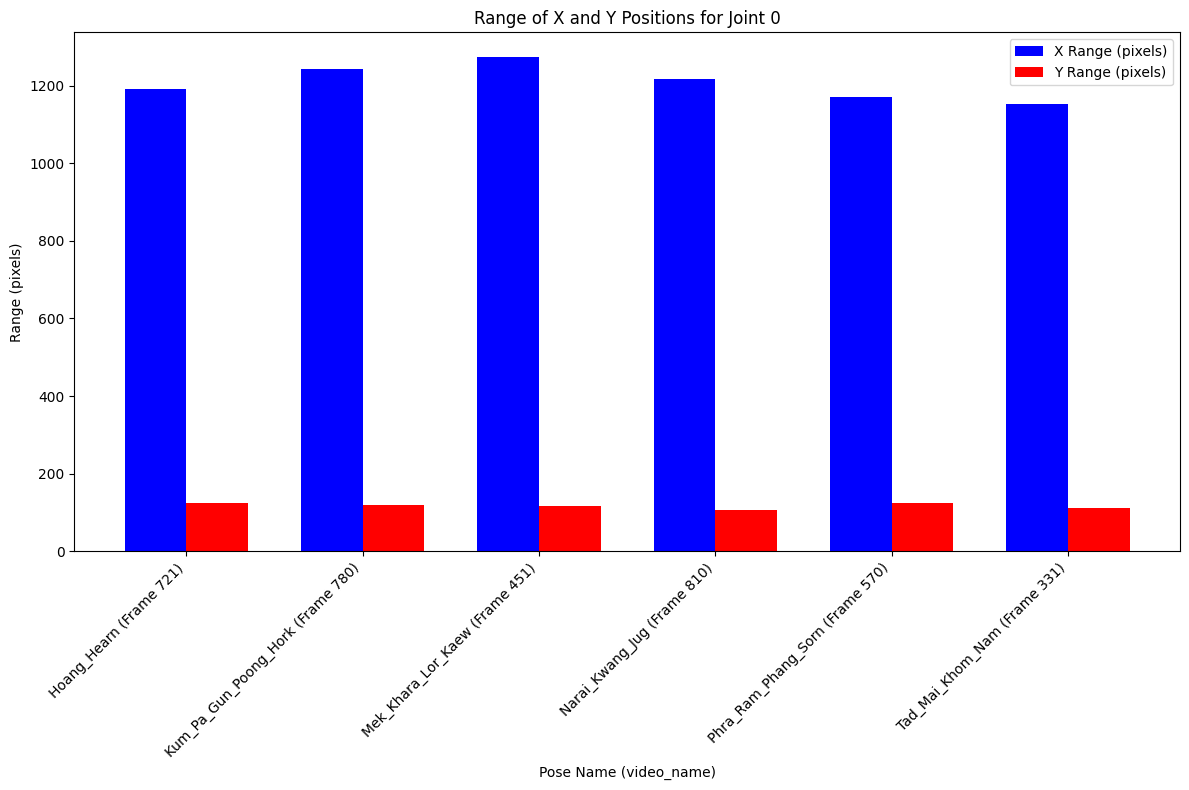

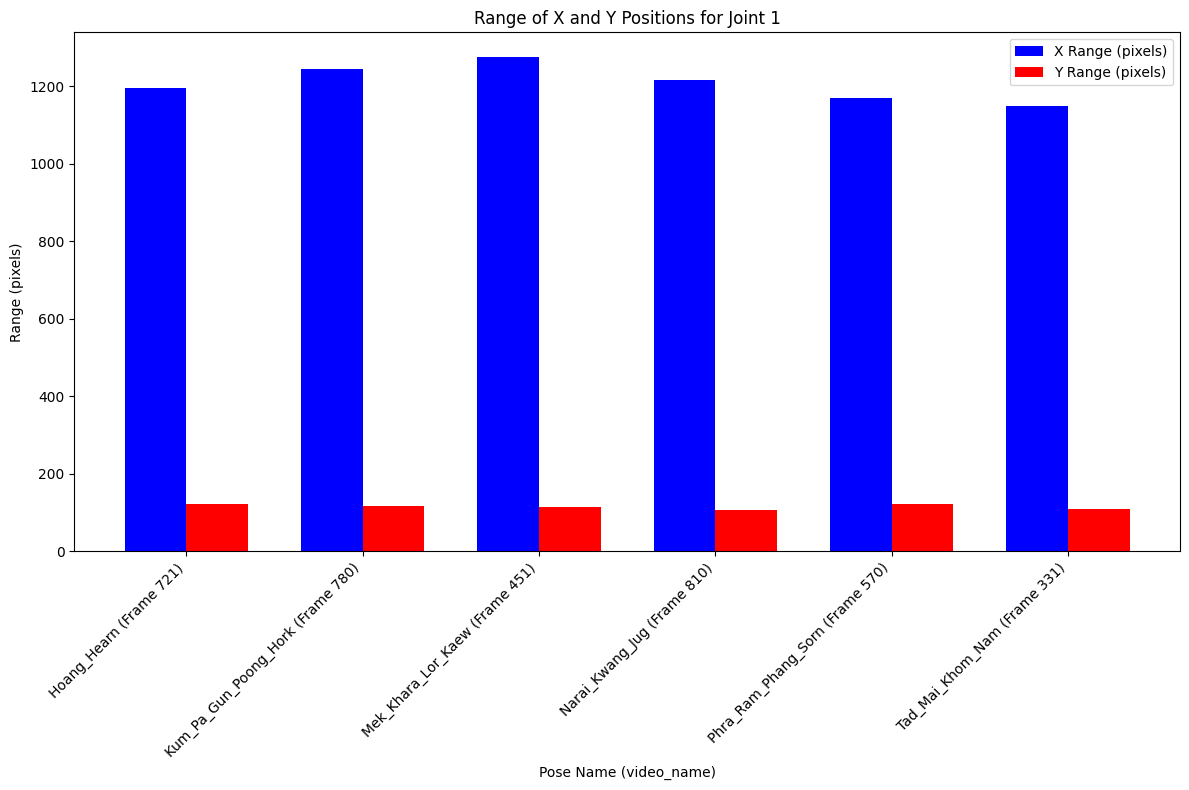

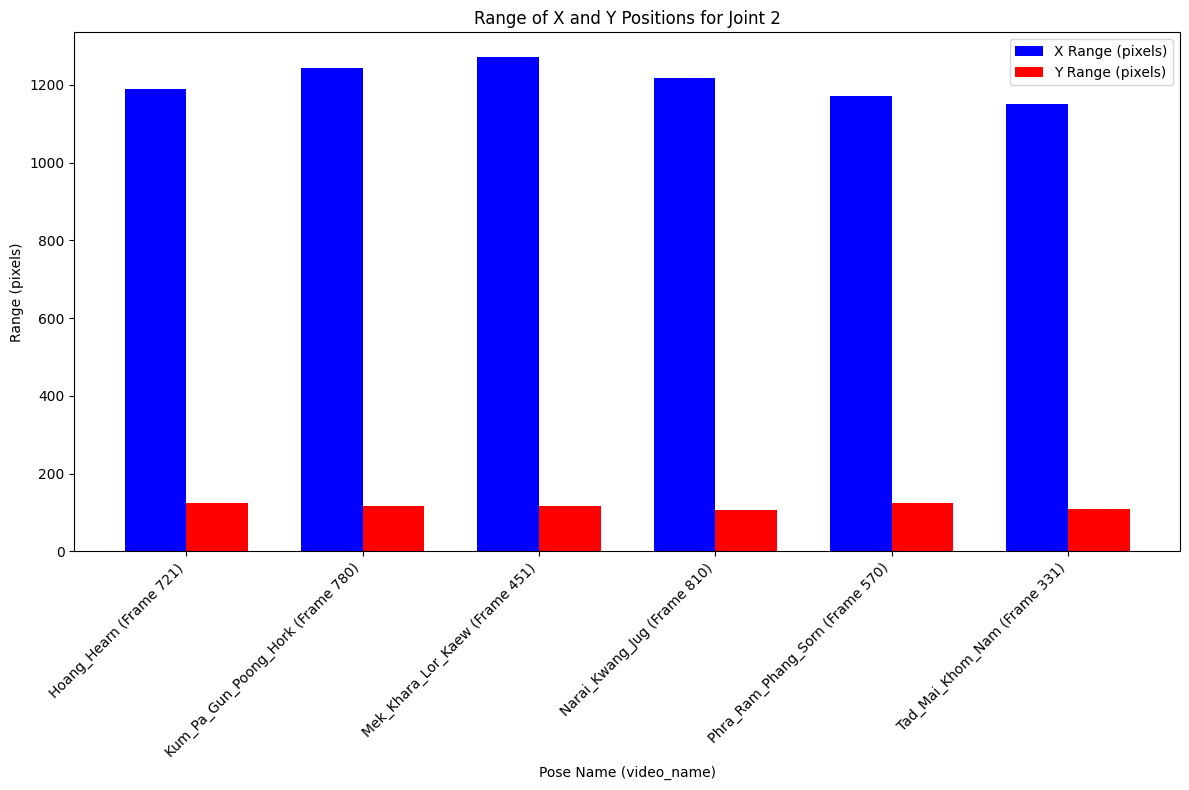

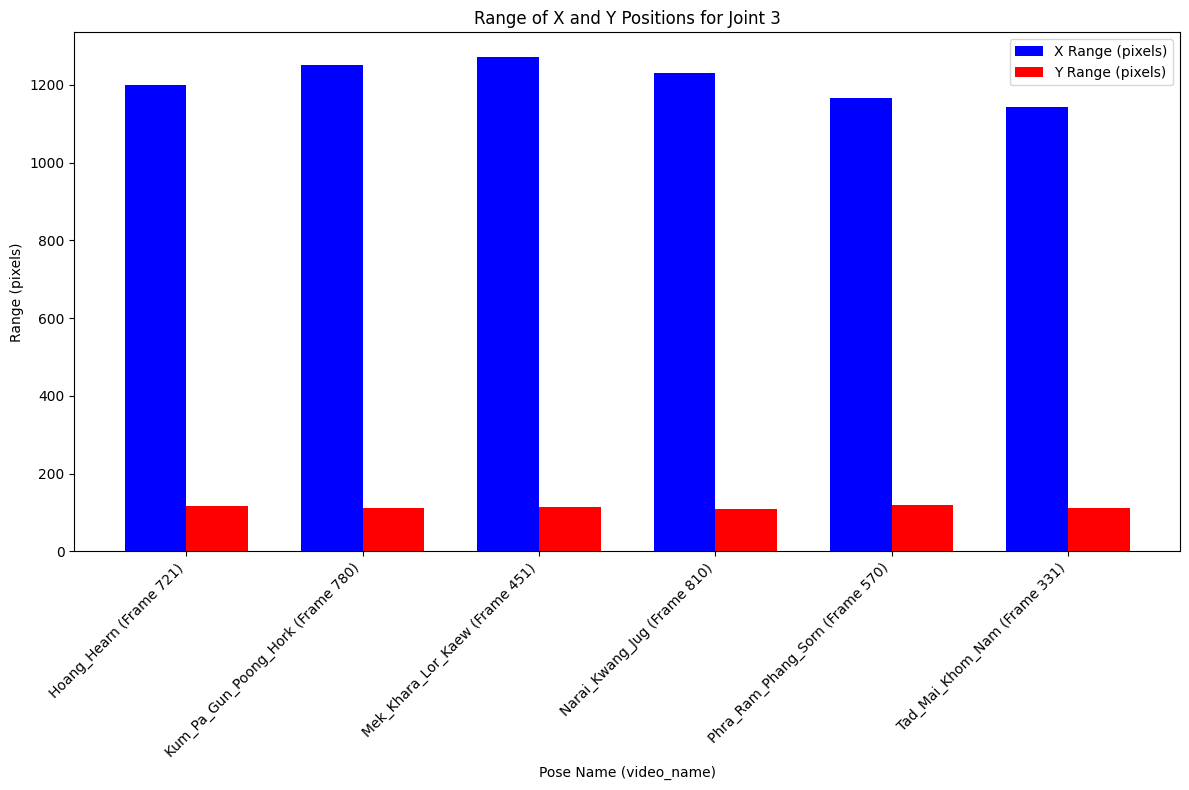

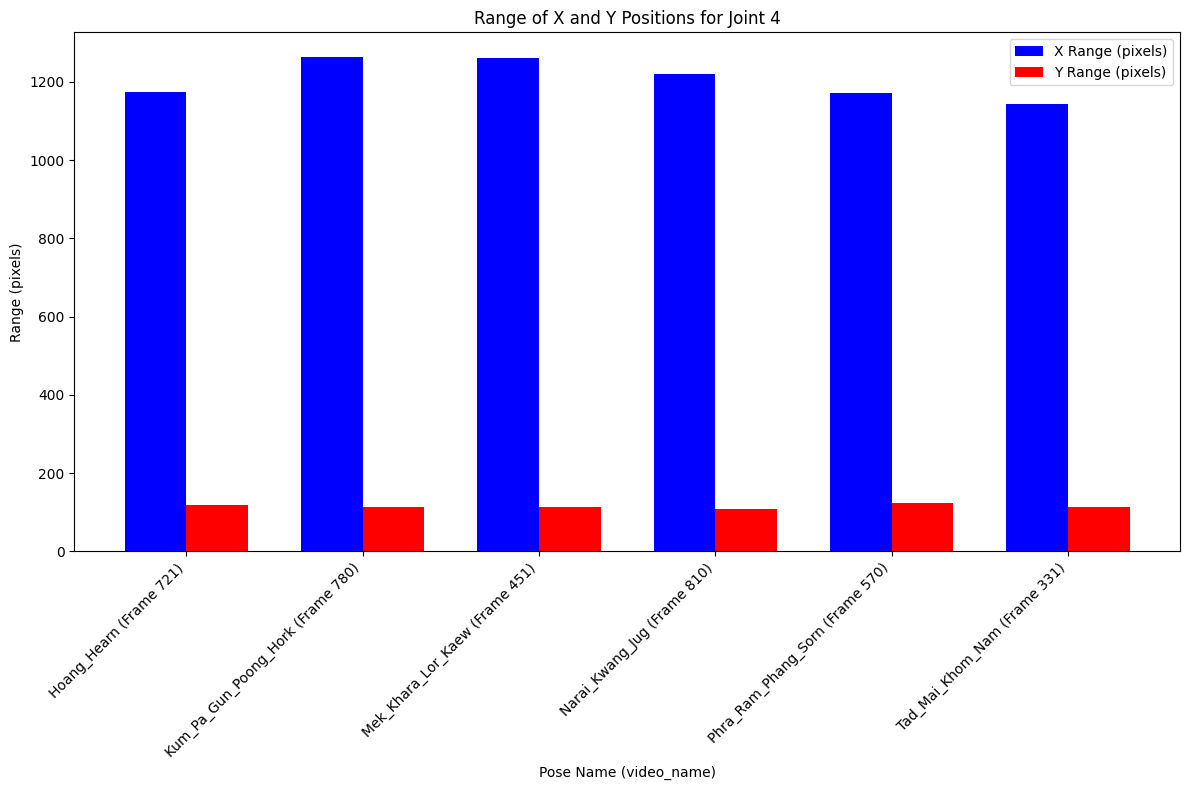

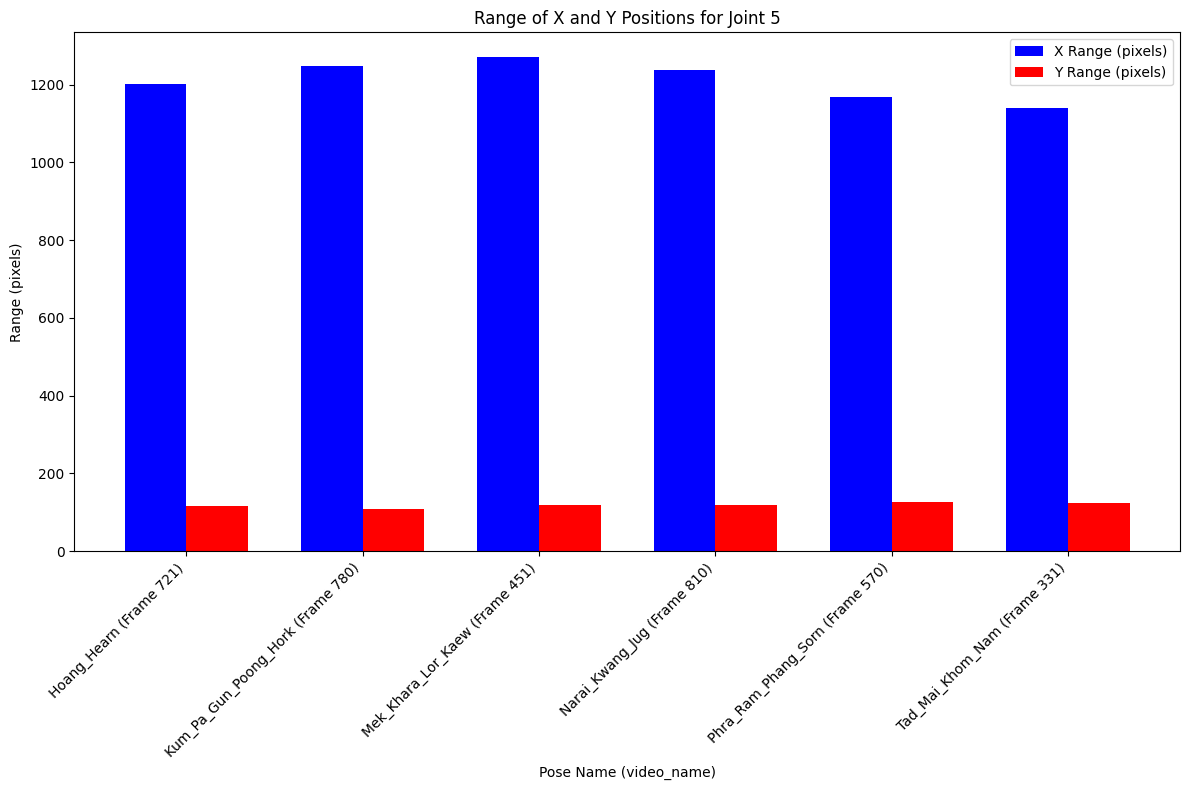

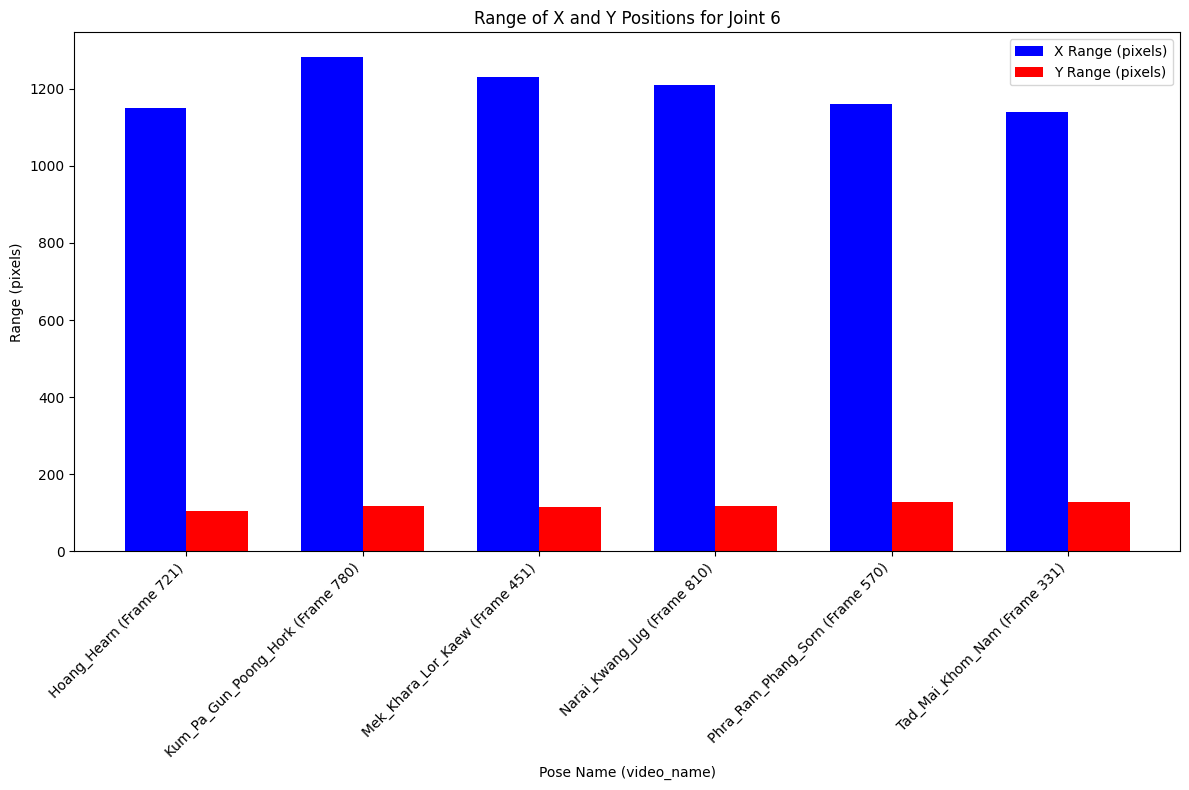

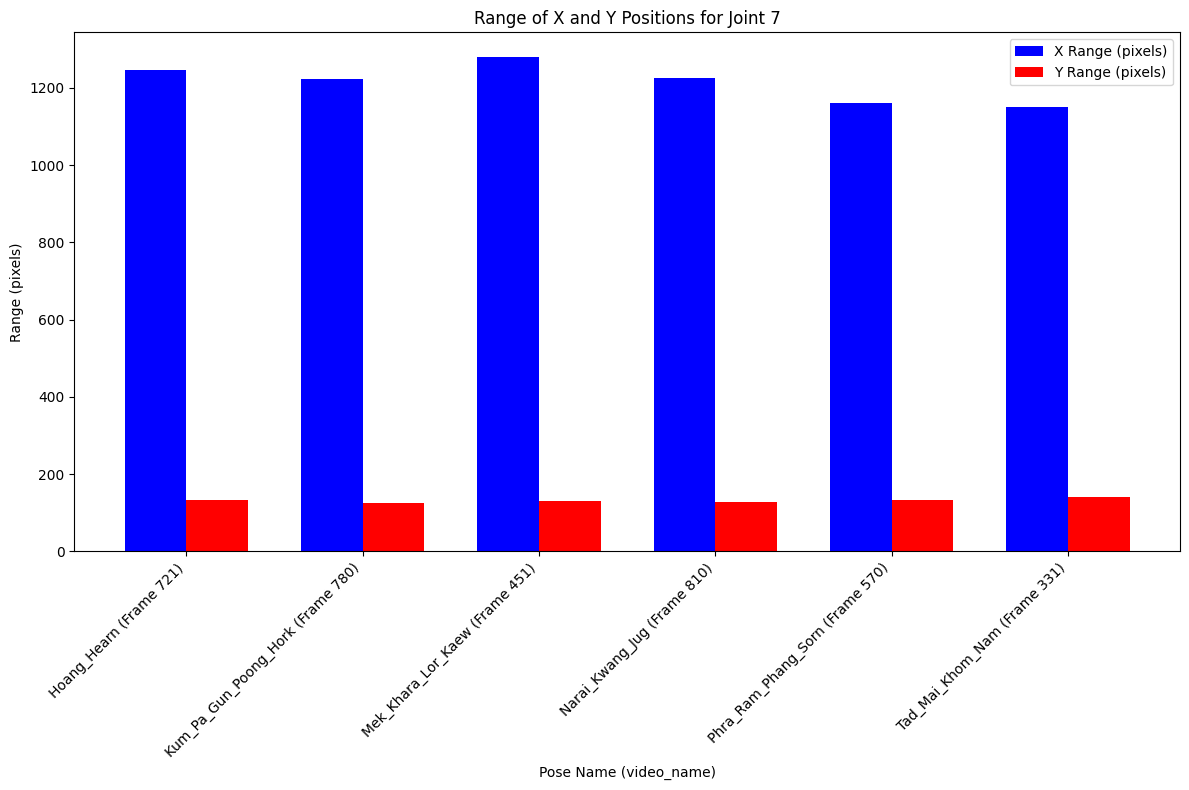

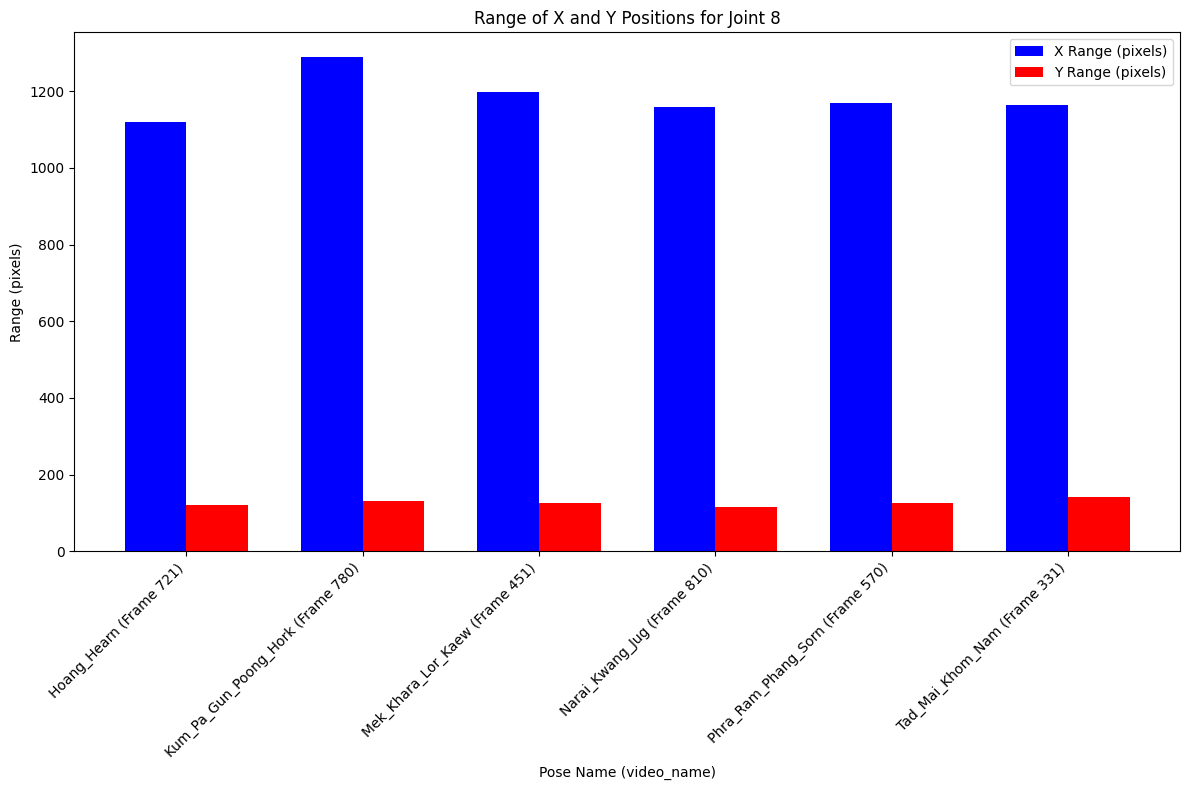

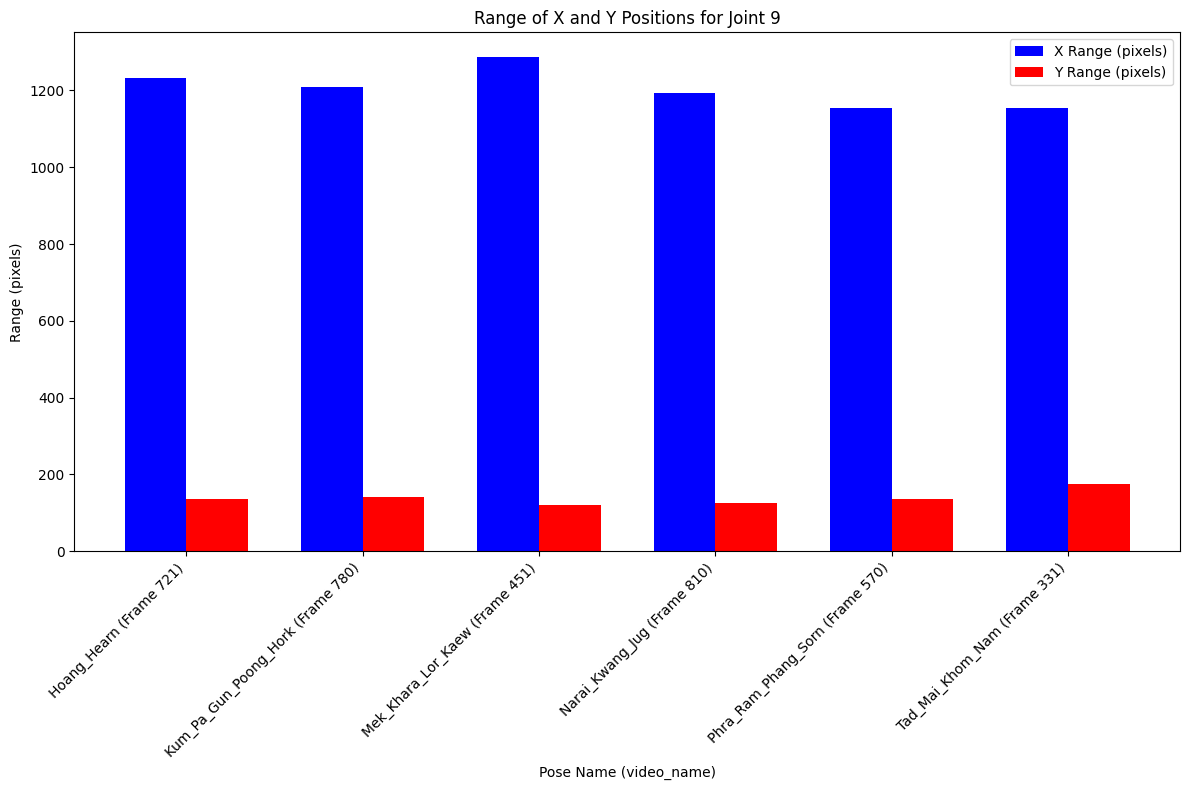

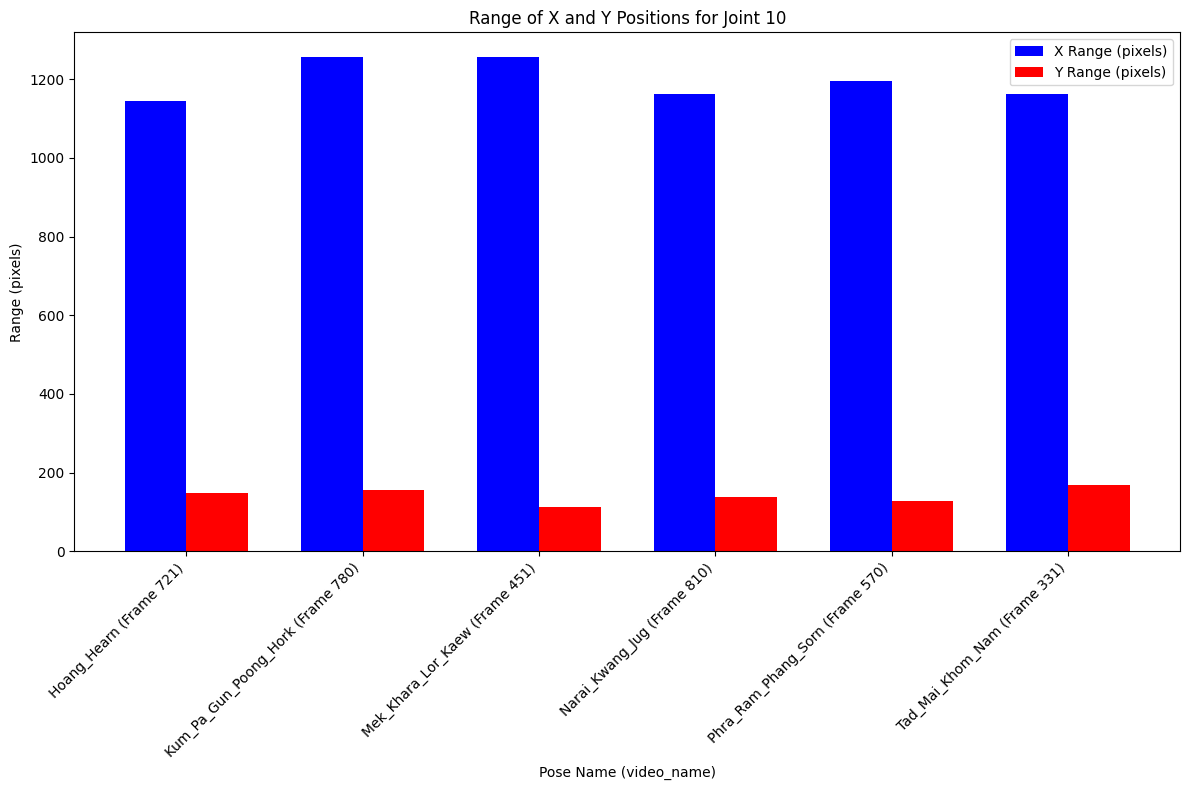

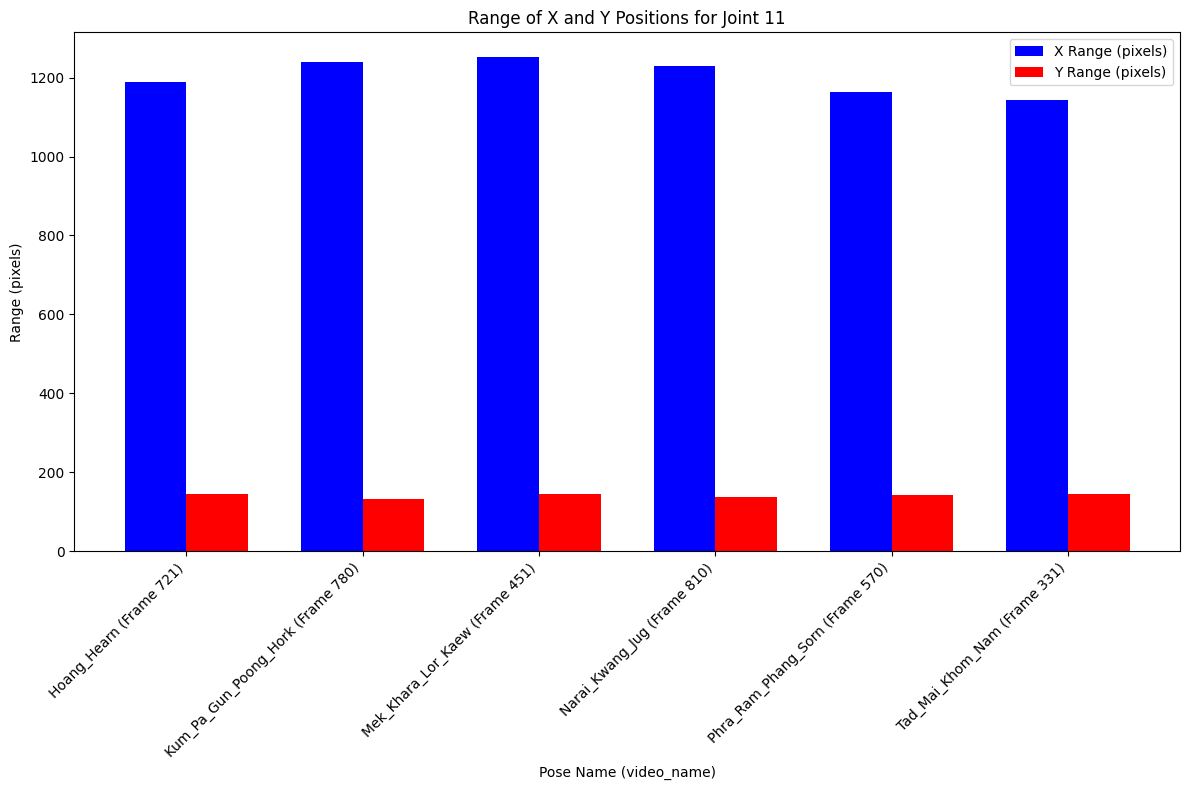

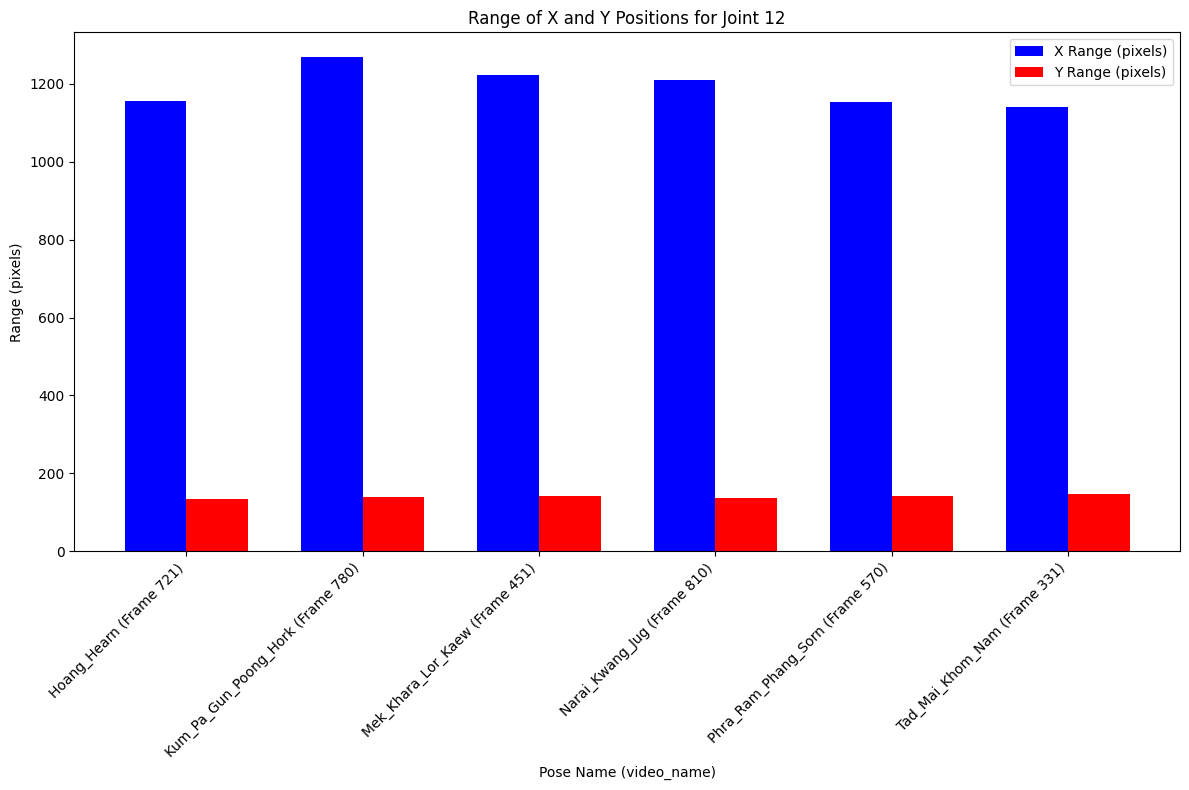

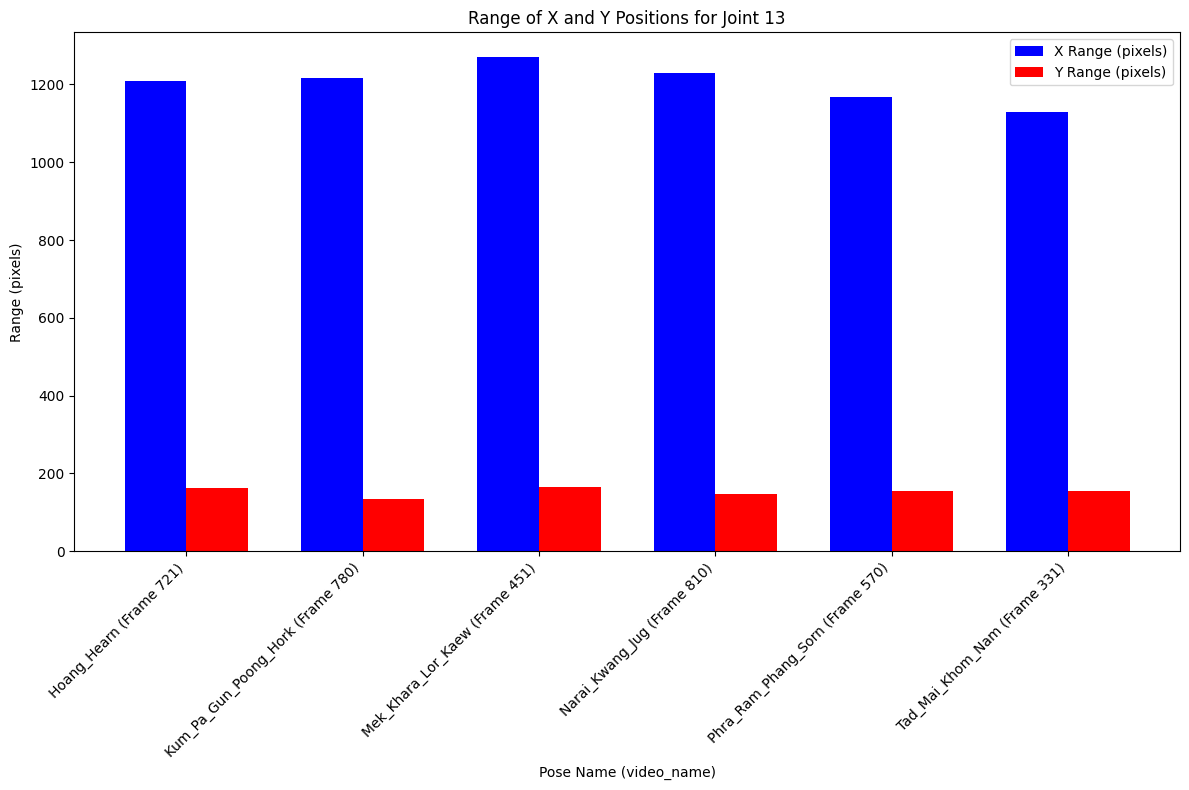

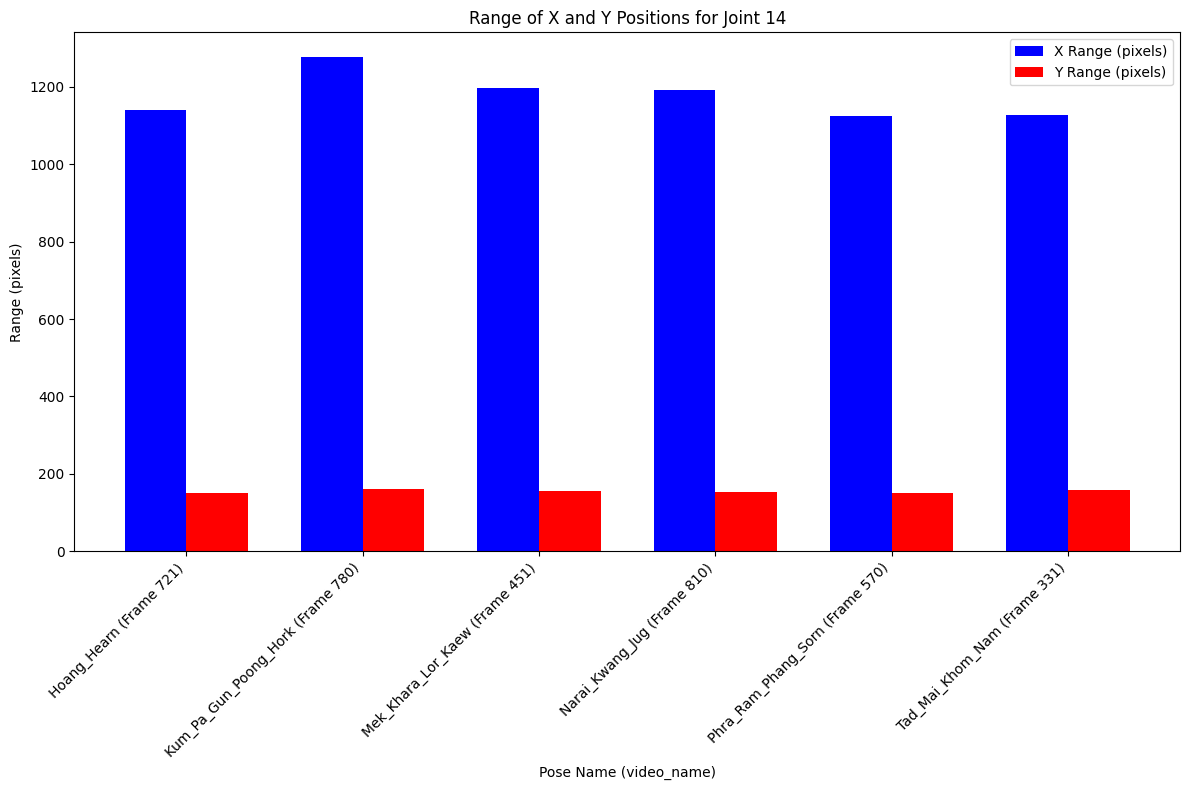

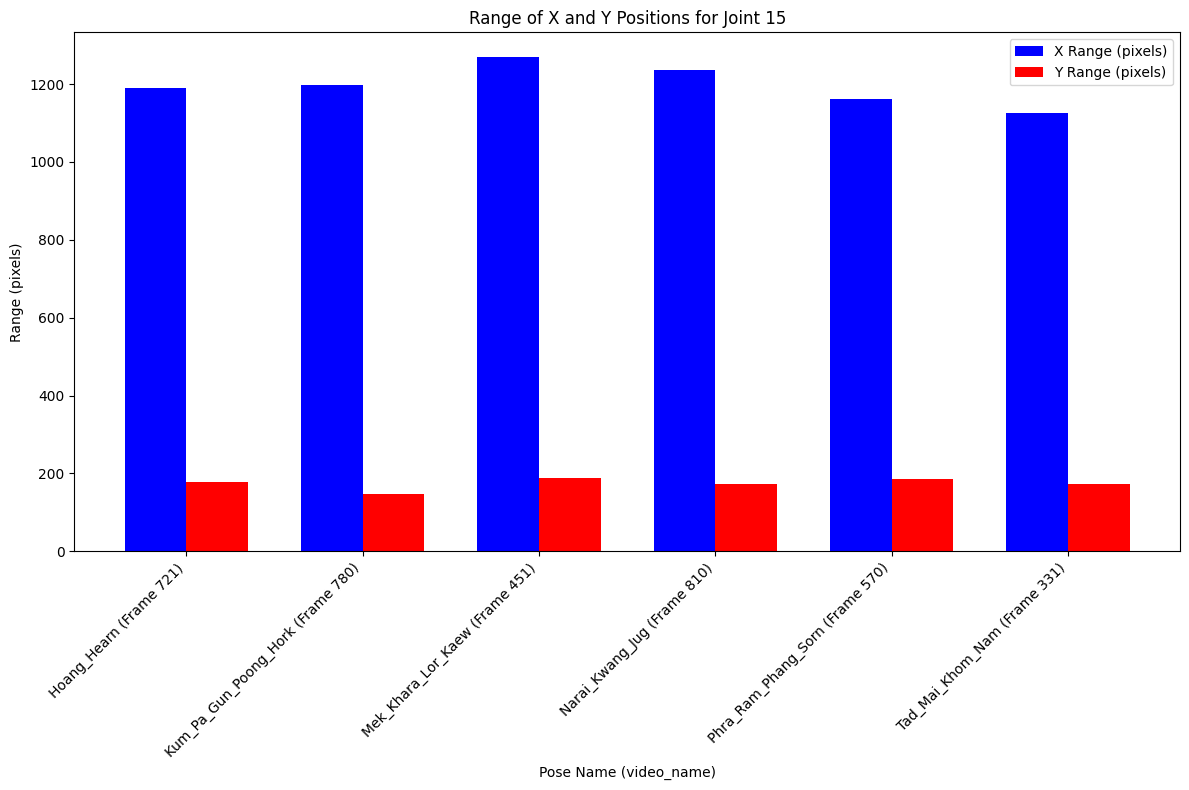

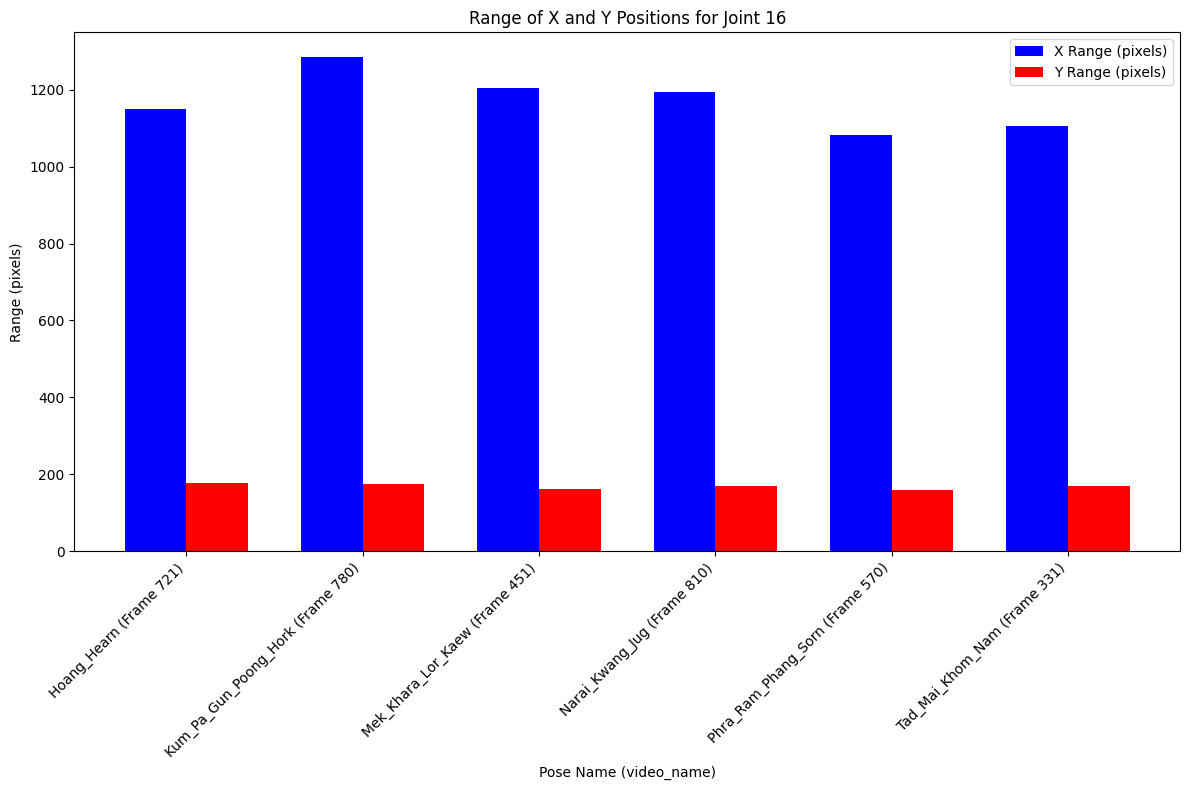

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# กรองข้อมูลเฉพาะ frame_id สุดท้ายของแต่ละ video_name
frame_data = df.groupby('video_name').apply(lambda x: x[x['frame_id'] == x['frame_id'].max()]).reset_index(drop=True)

# สร้างกราฟสำหรับแต่ละ joint_id
for joint_id, joint_group in frame_data.groupby('joint_id'):
    # สร้าง dictionaries เพื่อเก็บ range ของ x และ y สำหรับทุก video_name
    joint_x_range = {}
    joint_y_range = {}
    labels = []

    # คำนวณ range ของ x และ y สำหรับแต่ละ video_name
    for video_name, video_group in joint_group.groupby('video_name'):
        # คำนวณ range ของ x และ y
        x_range = (video_group['x'].min(), video_group['x'].max())
        y_range = (video_group['y'].min(), video_group['y'].max())
        
        # เก็บค่า range ใน dictionary
        joint_x_range[video_name] = x_range
        joint_y_range[video_name] = y_range
        labels.append(f'{video_name} (Frame {video_group["frame_id"].iloc[0]})')

    # Convert to lists for plotting
    x_ranges = [range_tuple[1] - range_tuple[0] for range_tuple in joint_x_range.values()]
    y_ranges = [range_tuple[1] - range_tuple[0] for range_tuple in joint_y_range.values()]

    # สร้างกราฟ Bar Plot เพื่อแสดง range ของ x และ y สำหรับทุก video_name
    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.35
    index = np.arange(len(labels))

    # พล็อต x range และ y range ในกราฟเดียวกัน
    bar1 = ax.bar(index, x_ranges, bar_width, label='X Range (pixels)', color='blue')
    bar2 = ax.bar(index + bar_width, y_ranges, bar_width, label='Y Range (pixels)', color='red')

    # ปรับแต่งกราฟ
    ax.set_xlabel('Pose Name (video_name)')
    ax.set_ylabel('Range (pixels)')
    ax.set_title(f'Range of X and Y Positions for Joint {joint_id}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()


ตอนเริ่มกับตอนจบของเเต่ละท่ามี x, y ของเเต่ละ joint ใกล้เคียงกันหมด -> จากการสังเกตในวิดีโอ จะมีท่าเริ่มต้นก่อนทำท่าต่างๆเป็นท่าเดียวกัน (ยืนตรง ตั้งการ์ด เท้าแยกขนาดลำตัว เท้านึงเก้าไปข้างหน้าเล็กน้อย ไม่ว่าจะหันหน้า หรือหันหลัง)

In [20]:
import math

grouped = df[(df['frame_id'] == 0)].groupby('joint_id')

for id, group in grouped:
    print(f"Joint ID: {id}")
    # Min ปัดลง เอาขอบล่างจริงๆ Max ปัดขึ้น เอาขอบบนจริงๆ
    print(f"X: Min - {math.floor(group['x'].min())}, Max - {math.ceil(group['x'].max())}")
    print(f"Y: Min - {math.floor(group['y'].min())}, Max - {math.ceil(group['y'].max())}")
    print("=" * 70)

Joint ID: 0
X: Min - 257, Max - 1575
Y: Min - 513, Max - 649
Joint ID: 1
X: Min - 260, Max - 1583
Y: Min - 508, Max - 641
Joint ID: 2
X: Min - 258, Max - 1571
Y: Min - 507, Max - 641
Joint ID: 3
X: Min - 264, Max - 1600
Y: Min - 511, Max - 640
Joint ID: 4
X: Min - 286, Max - 1576
Y: Min - 509, Max - 642
Joint ID: 5
X: Min - 260, Max - 1617
Y: Min - 542, Max - 676
Joint ID: 6
X: Min - 302, Max - 1586
Y: Min - 529, Max - 682
Joint ID: 7
X: Min - 237, Max - 1634
Y: Min - 569, Max - 732
Joint ID: 8
X: Min - 291, Max - 1602
Y: Min - 518, Max - 732
Joint ID: 9
X: Min - 247, Max - 1595
Y: Min - 543, Max - 746
Joint ID: 10
X: Min - 294, Max - 1583
Y: Min - 508, Max - 745
Joint ID: 11
X: Min - 269, Max - 1596
Y: Min - 611, Max - 781
Joint ID: 12
X: Min - 294, Max - 1564
Y: Min - 606, Max - 783
Joint ID: 13
X: Min - 239, Max - 1604
Y: Min - 675, Max - 870
Joint ID: 14
X: Min - 290, Max - 1568
Y: Min - 643, Max - 875
Joint ID: 15
X: Min - 219, Max - 1613
Y: Min - 741, Max - 962
Joint ID: 16
X: Mi

ถ้าเเต่ละ joint อยู่ไม่เกิน min,max ของ x,y ***ครบทุก joint*** ถือว่าจบท่าและเริ่มท่าใหม่แล้ว ตัดที่ frame นั้นได้เลย

In [38]:
import numpy as np

# Define the min and max values for each joint (for example purposes, you can adjust these as needed)
joint_ranges = {
    0: {'x': (257, 1575), 'y': (513, 649)},
    1: {'x': (260, 1583), 'y': (508, 641)},
    2: {'x': (258, 1571), 'y': (507, 641)},
    3: {'x': (264, 1600), 'y': (511, 640)},
    4: {'x': (286, 1576), 'y': (509, 642)},
    5: {'x': (260, 1617), 'y': (542, 676)},
    6: {'x': (302, 1586), 'y': (529, 682)},
    7: {'x': (237, 1634), 'y': (569, 732)},
    8: {'x': (291, 1602), 'y': (518, 732)},
    9: {'x': (247, 1595), 'y': (543, 746)},
    10: {'x': (294, 1583), 'y': (508, 745)},
    11: {'x': (269, 1596), 'y': (611, 781)},
    12: {'x': (294, 1564), 'y': (606, 783)},
    13: {'x': (239, 1604), 'y': (675, 870)},
    14: {'x': (290, 1568), 'y': (643, 875)},
    15: {'x': (219, 1613), 'y': (741, 962)},
    16: {'x': (272, 1557), 'y': (687, 960)},
}

def check_person_pose(keypoints, person_id, joint_ranges):
    """
    ตรวจสอบว่า keypoints ของคนนี้อยู่ในช่วง min, max ของแต่ละ joint หรือไม่
    
    Parameters:
    keypoints : numpy array - keypoints ของคนในรูปแบบ [17, 2] (x, y)
    person_id : int - person_id ของบุคคลที่ตรวจสอบ
    joint_ranges : dict - ค่า min, max สำหรับ x, y ของแต่ละ joint
    
    Returns:
    bool - True ถ้าทุก joint อยู่ในช่วง min-max, False ถ้าไม่
    """
    is_pose_end = True  # เริ่มต้นสมมติว่าเป็นท่าจบ

    for joint_id in range(17):  # 17 joints
        if joint_id in joint_ranges:
            x_value, y_value = keypoints[joint_id]

            # ค่า min-max สำหรับ x, y
            x_min, x_max = joint_ranges[joint_id]['x']
            y_min, y_max = joint_ranges[joint_id]['y']

            # ถ้า x, y ไม่อยู่ในช่วงที่กำหนดจะไม่ถือว่าเป็นท่าจบ
            if not (x_min <= x_value <= x_max and y_min <= y_value <= y_max):
                is_pose_end = False
                break  # ถ้ามี joint ใดไม่อยู่ในช่วง min-max ให้หยุด

    return is_pose_end

# ตัวอย่างการใช้งานกับ keypoints ของแต่ละคน
video_files = [
    "Mek_Khara_Lor_Kaew.mp4",
    "Kum_Pa_Gun_Poong_Hork.mp4",
    "Narai_Kwang_Jug.mp4",
    "Hoang_Hearn.mp4",
    "Phra_Ram_Phang_Sorn.mp4",
    "Tad_Mai_Khom_Nam.mp4"
]

rows = []

INSIDE_HOLD_FRAMES  = 5   # ต้องเข้า pose ติดกันกี่เฟรมถึงนับ START
OUTSIDE_HOLD_FRAMES = 5   # ต้องหลุด pose กี่เฟรมถึงนับ END

pose_state = {}   # (video_name, person_id) -> dict

for video_path in video_files:
    video_name = video_path.replace(".mp4", "")
    cap = cv2.VideoCapture(video_path)
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = pose_model(frame, conf=0.25, device=0, verbose=False)
        r = results[0]

        if r.keypoints is None:
            frame_id += 1
            continue

        keypoints = r.keypoints.xy.cpu().numpy()

        for person_id, person_kpts in enumerate(keypoints):
            key = (video_name, person_id)

            if key not in pose_state:
                pose_state[key] = {
                    "state": "OUTSIDE",
                    "inside_count": 0,
                    "outside_count": 0
                }

            is_inside = check_person_pose(
                person_kpts,
                person_id,
                joint_ranges
            )

            st = pose_state[key]

            # -------- OUTSIDE --------
            if st["state"] == "OUTSIDE":
                if is_inside:
                    st["inside_count"] += 1
                    if st["inside_count"] >= INSIDE_HOLD_FRAMES:
                        rows.append({
                            "video_name": video_name,
                            "frame_id": frame_id,
                            "person_id": person_id,
                            "event": "START"
                        })
                        st["state"] = "INSIDE"
                        st["inside_count"] = 0
                else:
                    st["inside_count"] = 0

            # -------- INSIDE --------
            else:  # INSIDE
                if not is_inside:
                    st["outside_count"] += 1
                    if st["outside_count"] >= OUTSIDE_HOLD_FRAMES:
                        rows.append({
                            "video_name": video_name,
                            "frame_id": frame_id,
                            "person_id": person_id,
                            "event": "END"
                        })
                        st["state"] = "OUTSIDE"
                        st["outside_count"] = 0
                else:
                    st["outside_count"] = 0

        frame_id += 1


In [39]:
tmp = pd.DataFrame(rows)
tmp.head()

,video_name,frame_id,person_id,event
0,Mek_Khara_Lor_Kaew,4,0,START
1,Mek_Khara_Lor_Kaew,4,1,START
2,Mek_Khara_Lor_Kaew,4,2,START
3,Mek_Khara_Lor_Kaew,4,3,START
4,Mek_Khara_Lor_Kaew,4,4,START


In [41]:
tmp[(tmp['video_name'] == 'Mek_Khara_Lor_Kaew') & (tmp['person_id'] == 0)]

,video_name,frame_id,person_id,event
0,Mek_Khara_Lor_Kaew,4,0,START
13,Mek_Khara_Lor_Kaew,39,0,END
24,Mek_Khara_Lor_Kaew,76,0,START
38,Mek_Khara_Lor_Kaew,226,0,END
49,Mek_Khara_Lor_Kaew,270,0,START
51,Mek_Khara_Lor_Kaew,276,0,END
79,Mek_Khara_Lor_Kaew,445,0,START


In [42]:
df[(df['video_name'] == 'Mek_Khara_Lor_Kaew') & (df['person_id'] == 0) & (df['joint_id'] == 0)].tail()

,video_name,frame_id,person_id,joint_id,x,y,score
298350,Mek_Khara_Lor_Kaew,447,0,0,1587.247192,632.478760,0.973694
298503,Mek_Khara_Lor_Kaew,448,0,0,1583.035034,635.016541,0.967753
298656,Mek_Khara_Lor_Kaew,449,0,0,1581.331787,637.907104,0.985500
298809,Mek_Khara_Lor_Kaew,450,0,0,1574.784302,639.622437,0.988403
298962,Mek_Khara_Lor_Kaew,451,0,0,1571.451416,640.089661,0.984718


In [43]:
tmp[(tmp['video_name'] == 'Kum_Pa_Gun_Poong_Hork') & (tmp['person_id'] == 0)]

,video_name,frame_id,person_id,event
88,Kum_Pa_Gun_Poong_Hork,6,0,START
93,Kum_Pa_Gun_Poong_Hork,24,0,END
99,Kum_Pa_Gun_Poong_Hork,69,0,START
100,Kum_Pa_Gun_Poong_Hork,74,0,END
103,Kum_Pa_Gun_Poong_Hork,79,0,START
107,Kum_Pa_Gun_Poong_Hork,87,0,END
110,Kum_Pa_Gun_Poong_Hork,106,0,START
116,Kum_Pa_Gun_Poong_Hork,123,0,END
141,Kum_Pa_Gun_Poong_Hork,260,0,START
143,Kum_Pa_Gun_Poong_Hork,275,0,END


In [44]:
df[(df['video_name'] == 'Kum_Pa_Gun_Poong_Hork') & (df['person_id'] == 0) & (df['joint_id'] == 0)].tail()

,video_name,frame_id,person_id,joint_id,x,y,score
229194,Kum_Pa_Gun_Poong_Hork,776,0,0,1565.204834,634.595581,0.033315
229347,Kum_Pa_Gun_Poong_Hork,777,0,0,1564.860840,634.278259,0.032557
229500,Kum_Pa_Gun_Poong_Hork,778,0,0,1562.325195,633.582764,0.027519
229653,Kum_Pa_Gun_Poong_Hork,779,0,0,1562.659668,634.064453,0.027258
229806,Kum_Pa_Gun_Poong_Hork,780,0,0,1562.765381,634.556030,0.027797
